In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.spectrum import (
    SpectrumDatasetOnOff,
    SpectrumDataset,
    SpectrumDatasetMaker,
)
from gammapy.modeling import Fit, Parameter
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SpectralModel,
    SkyModel,
    ExpCutoffPowerLawSpectralModel,
)
from gammapy.irf import load_cta_irfs
from gammapy.data import Observation
from gammapy.maps import MapAxis
from itertools import combinations

In [3]:
livetime = 48 * u.h
n_obs = 1000
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")
offset = 0.5 * u.deg
# Reconstructed and true energy axis
energy_axis = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 10), unit="TeV", name="energy", interp="log"
)
energy_axis_true = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 31), unit="TeV", name="energy", interp="log"
)

on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=pointing, radius=on_region_radius)

In [4]:
os.environ['CALDB'] = '/home/rishank/anaconda2/envs/cta/share/caldb/'
!echo $CALDB
!ls $CALDB

/home/rishank/anaconda2/envs/cta/share/caldb/
data


In [5]:
model_simu = PowerLawSpectralModel(
    index=2.22,
    amplitude=1.289e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
)
print(model_simu)
model = [] 
mod = SkyModel(spectral_model=model_simu)
model.append(mod)

PowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True


In [6]:
l = [0.01,0.1,0.2,0.3,0.5,1,2,3,5]
simu = []
for i in range(9):
    sim = ExpCutoffPowerLawSpectralModel(
        index=2.22,
        amplitude=1.289e-12 * u.Unit("cm-2 s-1 TeV-1"),
        reference=1 * u.TeV,
        lambda_=l[i] * u.Unit("TeV-1"),
        alpha = 1,
    )
    mod = SkyModel(spectral_model=sim)
    simu.append(sim)
    model.append(mod)
    print(model[i+1])
    print(simu[i])

SkyModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.000e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
ExpCutoffPowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.000e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
SkyModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  Fa

In [7]:
irfs = load_cta_irfs(
    "$CALDB/data/cta/prod3b-v2/bcf/South_z20_50h/irf_file.fits"
)

In [8]:
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 172800.0 s



In [9]:
dataset_empty = SpectrumDataset.create(
    e_reco=energy_axis.edges, e_true=energy_axis_true.edges, region=on_region
)
maker = SpectrumDatasetMaker(selection=["aeff", "edisp", "background"])
dataset = maker.run(dataset_empty, obs)

In [10]:
data = []
for i in range(len(model)):
    dataset.model = model[i]
    dataset.fake(random_state=42)
    print(dataset)
    data.append(dataset)

SpectrumDataset

    Name                            : 1 

    Total counts                    : 20280 
    Total predicted counts          : nan
    Total background counts         : 20309.41

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 1.73e+05 s

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : cash
    Fit statistic value (-2 log(L)) : nan

    Number of parameters            : 0
    Number of free parameters       : 0


SpectrumDataset

    Name                            : 1 

    Total counts                    : 20280 
    Total predicted counts          : nan
    Total background counts         : 20309.41

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 1.73e+05 s

    Number of total bins            : 9 
    Number of fit 

In [11]:
data_onoff = []
for i in range(len(model)):
    dataset_onoff = SpectrumDatasetOnOff(
        aeff=dataset.aeff,
        edisp=dataset.edisp,
        models=model[i],
        livetime=livetime,
        acceptance=1,
        acceptance_off=5,
    )
    dataset_onoff.fake(background_model=dataset.background)
    print(dataset_onoff)
    data_onoff.append(dataset_onoff)

SpectrumDatasetOnOff

    Name                            :  

    Total counts                    : 37412 
    Total predicted counts          : 37152.94
    Total off counts                : 101135.00

    Total background counts         : 20227.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.46

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            :  

    Total counts                    : 36735 
    Total predicted counts          : 37100.74
    Total off counts                : 101958.00

    Total background counts         : 20391.60

 

In [12]:
%%time
datas = []
for i in range(len(model)):
    datasets = []
    for idx in range(n_obs):
        data_onoff[i].fake(random_state=idx, background_model=dataset.background)
        data_onoff[i].name = f"obs_{idx}"
        datasets.append(data_onoff[i].copy())
    datas.append(datasets)

CPU times: user 1min, sys: 405 ms, total: 1min
Wall time: 1min 44s


In [13]:
len(datas)
print(*datas[0], sep = "\n")

SpectrumDatasetOnOff

    Name                            : obs_0 

    Total counts                    : 37107 
    Total predicted counts          : 37257.94
    Total off counts                : 101660.00

    Total background counts         : 20332.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.87

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1 

    Total counts                    : 36990 
    Total predicted counts          : 37192.34
    Total off counts                : 101332.00

    Total background counts         : 2


SpectrumDatasetOnOff

    Name                            : obs_19 

    Total counts                    : 37002 
    Total predicted counts          : 37212.94
    Total off counts                : 101435.00

    Total background counts         : 20287.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.12

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_20 

    Total counts                    : 37440 
    Total predicted counts          : 37183.14
    Total off counts                : 101286.00

    Total background counts         :

SpectrumDatasetOnOff

    Name                            : obs_30 

    Total counts                    : 37640 
    Total predicted counts          : 37169.54
    Total off counts                : 101218.00

    Total background counts         : 20243.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 15.48

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_31 

    Total counts                    : 36925 
    Total predicted counts          : 37182.94
    Total off counts                : 101285.00

    Total background counts         :

SpectrumDatasetOnOff

    Name                            : obs_47 

    Total counts                    : 37596 
    Total predicted counts          : 37184.54
    Total off counts                : 101293.00

    Total background counts         : 20258.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.81

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_48 

    Total counts                    : 36987 
    Total predicted counts          : 37146.14
    Total off counts                : 101101.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_58 

    Total counts                    : 37126 
    Total predicted counts          : 37250.14
    Total off counts                : 101621.00

    Total background counts         : 20324.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.64

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_59 

    Total counts                    : 37202 
    Total predicted counts          : 37391.54
    Total off counts                : 102328.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_73 

    Total counts                    : 37595 
    Total predicted counts          : 37178.34
    Total off counts                : 101262.00

    Total background counts         : 20252.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.69

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_74 

    Total counts                    : 37315 
    Total predicted counts          : 37173.94
    Total off counts                : 101240.00

    Total background counts         :


SpectrumDatasetOnOff

    Name                            : obs_87 

    Total counts                    : 37437 
    Total predicted counts          : 37240.34
    Total off counts                : 101572.00

    Total background counts         : 20314.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.86

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_88 

    Total counts                    : 37411 
    Total predicted counts          : 37275.94
    Total off counts                : 101750.00

    Total background counts         :

SpectrumDatasetOnOff

    Name                            : obs_102 

    Total counts                    : 37016 
    Total predicted counts          : 37234.14
    Total off counts                : 101541.00

    Total background counts         : 20308.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.14

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_103 

    Total counts                    : 37227 
    Total predicted counts          : 37227.34
    Total off counts                : 101507.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_114 

    Total counts                    : 37553 
    Total predicted counts          : 37132.74
    Total off counts                : 101034.00

    Total background counts         : 20206.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.85

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_115 

    Total counts                    : 37417 
    Total predicted counts          : 37124.54
    Total off counts                : 100993.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_134 

    Total counts                    : 37184 
    Total predicted counts          : 37242.94
    Total off counts                : 101585.00

    Total background counts         : 20317.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.13

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_135 

    Total counts                    : 37396 
    Total predicted counts          : 37187.34
    Total off counts                : 101307.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_146 

    Total counts                    : 37420 
    Total predicted counts          : 37233.14
    Total off counts                : 101536.00

    Total background counts         : 20307.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.80

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_147 

    Total counts                    : 37019 
    Total predicted counts          : 37216.54
    Total off counts                : 101453.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_157 

    Total counts                    : 37399 
    Total predicted counts          : 37262.54
    Total off counts                : 101683.00

    Total background counts         : 20336.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.85

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_158 

    Total counts                    : 37466 
    Total predicted counts          : 37319.94
    Total off counts                : 101970.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_168 

    Total counts                    : 37520 
    Total predicted counts          : 37229.94
    Total off counts                : 101520.00

    Total background counts         : 20304.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.15

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_169 

    Total counts                    : 37288 
    Total predicted counts          : 37239.74
    Total off counts                : 101569.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_180 

    Total counts                    : 37271 
    Total predicted counts          : 37278.54
    Total off counts                : 101763.00

    Total background counts         : 20352.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.59

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_181 

    Total counts                    : 37210 
    Total predicted counts          : 37280.74
    Total off counts                : 101774.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_191 

    Total counts                    : 36761 
    Total predicted counts          : 37289.54
    Total off counts                : 101818.00

    Total background counts         : 20363.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 20.21

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_192 

    Total counts                    : 37085 
    Total predicted counts          : 37239.14
    Total off counts                : 101566.00

    Total background counts        


SpectrumDatasetOnOff

    Name                            : obs_202 

    Total counts                    : 37342 
    Total predicted counts          : 37255.74
    Total off counts                : 101649.00

    Total background counts         : 20329.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.84

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_203 

    Total counts                    : 37427 
    Total predicted counts          : 37213.54
    Total off counts                : 101438.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_219 

    Total counts                    : 37102 
    Total predicted counts          : 37247.34
    Total off counts                : 101607.00

    Total background counts         : 20321.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 16.80

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_220 

    Total counts                    : 37100 
    Total predicted counts          : 37207.54
    Total off counts                : 101408.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_230 

    Total counts                    : 37512 
    Total predicted counts          : 37317.34
    Total off counts                : 101957.00

    Total background counts         : 20391.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.97

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_231 

    Total counts                    : 37402 
    Total predicted counts          : 37330.94
    Total off counts                : 102025.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_241 

    Total counts                    : 37387 
    Total predicted counts          : 37179.14
    Total off counts                : 101266.00

    Total background counts         : 20253.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.26

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_242 

    Total counts                    : 37290 
    Total predicted counts          : 37110.74
    Total off counts                : 100924.00

    Total background counts        


SpectrumDatasetOnOff

    Name                            : obs_252 

    Total counts                    : 37100 
    Total predicted counts          : 37294.54
    Total off counts                : 101843.00

    Total background counts         : 20368.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.28

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_253 

    Total counts                    : 36967 
    Total predicted counts          : 37343.54
    Total off counts                : 102088.00

    Total background counts        


SpectrumDatasetOnOff

    Name                            : obs_263 

    Total counts                    : 37132 
    Total predicted counts          : 37246.34
    Total off counts                : 101602.00

    Total background counts         : 20320.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.90

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_264 

    Total counts                    : 37212 
    Total predicted counts          : 37251.14
    Total off counts                : 101626.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_284 

    Total counts                    : 36859 
    Total predicted counts          : 37195.94
    Total off counts                : 101350.00

    Total background counts         : 20270.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.61

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_285 

    Total counts                    : 37056 
    Total predicted counts          : 37281.94
    Total off counts                : 101780.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_302 

    Total counts                    : 37066 
    Total predicted counts          : 37158.14
    Total off counts                : 101161.00

    Total background counts         : 20232.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.15

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_303 

    Total counts                    : 37174 
    Total predicted counts          : 37301.94
    Total off counts                : 101880.00

    Total background counts         


SpectrumDatasetOnOff

    Name                            : obs_313 

    Total counts                    : 37515 
    Total predicted counts          : 37290.54
    Total off counts                : 101823.00

    Total background counts         : 20364.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.44

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_314 

    Total counts                    : 37547 
    Total predicted counts          : 37133.74
    Total off counts                : 101039.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_324 

    Total counts                    : 37104 
    Total predicted counts          : 37319.94
    Total off counts                : 101970.00

    Total background counts         : 20394.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.81

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_325 

    Total counts                    : 37428 
    Total predicted counts          : 37201.34
    Total off counts                : 101377.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_342 

    Total counts                    : 37365 
    Total predicted counts          : 37148.34
    Total off counts                : 101112.00

    Total background counts         : 20222.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.69

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_343 

    Total counts                    : 37291 
    Total predicted counts          : 37214.14
    Total off counts                : 101441.00

    Total background counts         


SpectrumDatasetOnOff

    Name                            : obs_355 

    Total counts                    : 37281 
    Total predicted counts          : 37251.74
    Total off counts                : 101629.00

    Total background counts         : 20325.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.57

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_356 

    Total counts                    : 37312 
    Total predicted counts          : 37256.14
    Total off counts                : 101651.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_372 

    Total counts                    : 37115 
    Total predicted counts          : 37224.34
    Total off counts                : 101492.00

    Total background counts         : 20298.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.57

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_373 

    Total counts                    : 37220 
    Total predicted counts          : 37229.54
    Total off counts                : 101518.00

    Total background counts         


SpectrumDatasetOnOff

    Name                            : obs_385 

    Total counts                    : 37214 
    Total predicted counts          : 37128.54
    Total off counts                : 101013.00

    Total background counts         : 20202.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 18.55

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_386 

    Total counts                    : 37304 
    Total predicted counts          : 37133.34
    Total off counts                : 101037.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_401 

    Total counts                    : 37149 
    Total predicted counts          : 37214.54
    Total off counts                : 101443.00

    Total background counts         : 20288.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.45

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_402 

    Total counts                    : 37013 
    Total predicted counts          : 37227.74
    Total off counts                : 101509.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_414 

    Total counts                    : 37278 
    Total predicted counts          : 37191.14
    Total off counts                : 101326.00

    Total background counts         : 20265.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.24

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_415 

    Total counts                    : 36948 
    Total predicted counts          : 37252.54
    Total off counts                : 101633.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_427 

    Total counts                    : 37324 
    Total predicted counts          : 37039.74
    Total off counts                : 100569.00

    Total background counts         : 20113.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.81

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_428 

    Total counts                    : 37256 
    Total predicted counts          : 37229.54
    Total off counts                : 101518.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_445 

    Total counts                    : 37454 
    Total predicted counts          : 37190.74
    Total off counts                : 101324.00

    Total background counts         : 20264.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.62

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_446 

    Total counts                    : 37240 
    Total predicted counts          : 37271.94
    Total off counts                : 101730.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_465 

    Total counts                    : 37398 
    Total predicted counts          : 37195.74
    Total off counts                : 101349.00

    Total background counts         : 20269.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.97

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_466 

    Total counts                    : 37177 
    Total predicted counts          : 37155.54
    Total off counts                : 101148.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_476 

    Total counts                    : 37090 
    Total predicted counts          : 37242.34
    Total off counts                : 101582.00

    Total background counts         : 20316.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.65

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_477 

    Total counts                    : 37346 
    Total predicted counts          : 37291.34
    Total off counts                : 101827.00

    Total background counts         


SpectrumDatasetOnOff

    Name                            : obs_487 

    Total counts                    : 37557 
    Total predicted counts          : 37167.14
    Total off counts                : 101206.00

    Total background counts         : 20241.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 15.30

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_488 

    Total counts                    : 37245 
    Total predicted counts          : 37238.94
    Total off counts                : 101565.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_507 

    Total counts                    : 37127 
    Total predicted counts          : 37114.14
    Total off counts                : 100941.00

    Total background counts         : 20188.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.49

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_508 

    Total counts                    : 37186 
    Total predicted counts          : 37196.74
    Total off counts                : 101354.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_524 

    Total counts                    : 37170 
    Total predicted counts          : 37348.34
    Total off counts                : 102112.00

    Total background counts         : 20422.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.62

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_525 

    Total counts                    : 37408 
    Total predicted counts          : 37177.34
    Total off counts                : 101257.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_535 

    Total counts                    : 37256 
    Total predicted counts          : 37232.14
    Total off counts                : 101531.00

    Total background counts         : 20306.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.18

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_536 

    Total counts                    : 37283 
    Total predicted counts          : 37202.74
    Total off counts                : 101384.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_559 

    Total counts                    : 37381 
    Total predicted counts          : 37281.34
    Total off counts                : 101777.00

    Total background counts         : 20355.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.58

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_560 

    Total counts                    : 37114 
    Total predicted counts          : 37288.14
    Total off counts                : 101811.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_572 

    Total counts                    : 37170 
    Total predicted counts          : 37262.34
    Total off counts                : 101682.00

    Total background counts         : 20336.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.94

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_573 

    Total counts                    : 37419 
    Total predicted counts          : 37242.54
    Total off counts                : 101583.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_584 

    Total counts                    : 36970 
    Total predicted counts          : 37193.54
    Total off counts                : 101338.00

    Total background counts         : 20267.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.85

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_585 

    Total counts                    : 37347 
    Total predicted counts          : 37194.14
    Total off counts                : 101341.00

    Total background counts        


SpectrumDatasetOnOff

    Name                            : obs_605 

    Total counts                    : 37502 
    Total predicted counts          : 37249.34
    Total off counts                : 101617.00

    Total background counts         : 20323.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.92

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_606 

    Total counts                    : 37149 
    Total predicted counts          : 37186.54
    Total off counts                : 101303.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_624 

    Total counts                    : 37099 
    Total predicted counts          : 37245.34
    Total off counts                : 101597.00

    Total background counts         : 20319.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.30

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_625 

    Total counts                    : 36918 
    Total predicted counts          : 37331.54
    Total off counts                : 102028.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_635 

    Total counts                    : 37402 
    Total predicted counts          : 37222.34
    Total off counts                : 101482.00

    Total background counts         : 20296.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.40

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_636 

    Total counts                    : 37401 
    Total predicted counts          : 37304.54
    Total off counts                : 101893.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_646 

    Total counts                    : 36895 
    Total predicted counts          : 37366.54
    Total off counts                : 102203.00

    Total background counts         : 20440.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 21.86

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_647 

    Total counts                    : 37355 
    Total predicted counts          : 37229.74
    Total off counts                : 101519.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_666 

    Total counts                    : 37385 
    Total predicted counts          : 37199.14
    Total off counts                : 101366.00

    Total background counts         : 20273.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.96

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_667 

    Total counts                    : 37400 
    Total predicted counts          : 37280.54
    Total off counts                : 101773.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_686 

    Total counts                    : 36885 
    Total predicted counts          : 37193.14
    Total off counts                : 101336.00

    Total background counts         : 20267.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.84

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_687 

    Total counts                    : 37073 
    Total predicted counts          : 37222.74
    Total off counts                : 101484.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_706 

    Total counts                    : 37229 
    Total predicted counts          : 37368.74
    Total off counts                : 102214.00

    Total background counts         : 20442.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.28

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_707 

    Total counts                    : 37070 
    Total predicted counts          : 37182.74
    Total off counts                : 101284.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_725 

    Total counts                    : 37292 
    Total predicted counts          : 37224.14
    Total off counts                : 101491.00

    Total background counts         : 20298.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.45

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_726 

    Total counts                    : 37246 
    Total predicted counts          : 37290.14
    Total off counts                : 101821.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_736 

    Total counts                    : 37377 
    Total predicted counts          : 37301.34
    Total off counts                : 101877.00

    Total background counts         : 20375.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.44

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_737 

    Total counts                    : 36981 
    Total predicted counts          : 37184.54
    Total off counts                : 101293.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_757 

    Total counts                    : 37563 
    Total predicted counts          : 37218.54
    Total off counts                : 101463.00

    Total background counts         : 20292.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.52

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_758 

    Total counts                    : 37059 
    Total predicted counts          : 37265.74
    Total off counts                : 101699.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_778 

    Total counts                    : 37217 
    Total predicted counts          : 37178.54
    Total off counts                : 101263.00

    Total background counts         : 20252.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.43

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_779 

    Total counts                    : 37485 
    Total predicted counts          : 37248.14
    Total off counts                : 101611.00

    Total background counts         


SpectrumDatasetOnOff

    Name                            : obs_798 

    Total counts                    : 37357 
    Total predicted counts          : 37309.74
    Total off counts                : 101919.00

    Total background counts         : 20383.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.76

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_799 

    Total counts                    : 37613 
    Total predicted counts          : 37169.94
    Total off counts                : 101220.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_818 

    Total counts                    : 37272 
    Total predicted counts          : 37146.14
    Total off counts                : 101101.00

    Total background counts         : 20220.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.82

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_819 

    Total counts                    : 37220 
    Total predicted counts          : 37195.34
    Total off counts                : 101347.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_829 

    Total counts                    : 37093 
    Total predicted counts          : 37229.94
    Total off counts                : 101520.00

    Total background counts         : 20304.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.97

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_830 

    Total counts                    : 37359 
    Total predicted counts          : 37295.54
    Total off counts                : 101848.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_840 

    Total counts                    : 36973 
    Total predicted counts          : 37292.94
    Total off counts                : 101835.00

    Total background counts         : 20367.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.22

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_841 

    Total counts                    : 37464 
    Total predicted counts          : 37324.54
    Total off counts                : 101993.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_861 

    Total counts                    : 37010 
    Total predicted counts          : 37238.14
    Total off counts                : 101561.00

    Total background counts         : 20312.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.07

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_862 

    Total counts                    : 37372 
    Total predicted counts          : 37295.74
    Total off counts                : 101849.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_872 

    Total counts                    : 37117 
    Total predicted counts          : 37230.74
    Total off counts                : 101524.00

    Total background counts         : 20304.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.59

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_873 

    Total counts                    : 37045 
    Total predicted counts          : 37254.54
    Total off counts                : 101643.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_883 

    Total counts                    : 37134 
    Total predicted counts          : 37160.94
    Total off counts                : 101175.00

    Total background counts         : 20235.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.01

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_884 

    Total counts                    : 37279 
    Total predicted counts          : 37148.34
    Total off counts                : 101112.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_894 

    Total counts                    : 36990 
    Total predicted counts          : 37250.14
    Total off counts                : 101621.00

    Total background counts         : 20324.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.43

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_895 

    Total counts                    : 37401 
    Total predicted counts          : 37161.74
    Total off counts                : 101179.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_905 

    Total counts                    : 37175 
    Total predicted counts          : 37307.14
    Total off counts                : 101906.00

    Total background counts         : 20381.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.82

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_906 

    Total counts                    : 37506 
    Total predicted counts          : 37231.94
    Total off counts                : 101530.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_916 

    Total counts                    : 37804 
    Total predicted counts          : 37170.74
    Total off counts                : 101224.00

    Total background counts         : 20244.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 15.94

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_917 

    Total counts                    : 37611 
    Total predicted counts          : 37136.14
    Total off counts                : 101051.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_936 

    Total counts                    : 37387 
    Total predicted counts          : 37312.94
    Total off counts                : 101935.00

    Total background counts         : 20387.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.17

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_937 

    Total counts                    : 37746 
    Total predicted counts          : 37282.74
    Total off counts                : 101784.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_947 

    Total counts                    : 37120 
    Total predicted counts          : 37156.54
    Total off counts                : 101153.00

    Total background counts         : 20230.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.32

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_948 

    Total counts                    : 37086 
    Total predicted counts          : 37205.14
    Total off counts                : 101396.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_964 

    Total counts                    : 37383 
    Total predicted counts          : 37164.54
    Total off counts                : 101193.00

    Total background counts         : 20238.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.42

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_965 

    Total counts                    : 37441 
    Total predicted counts          : 37074.74
    Total off counts                : 100744.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_988 

    Total counts                    : 37083 
    Total predicted counts          : 37269.34
    Total off counts                : 101717.00

    Total background counts         : 20343.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.03

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_989 

    Total counts                    : 37113 
    Total predicted counts          : 37248.14
    Total off counts                : 101611.00

    Total background counts        

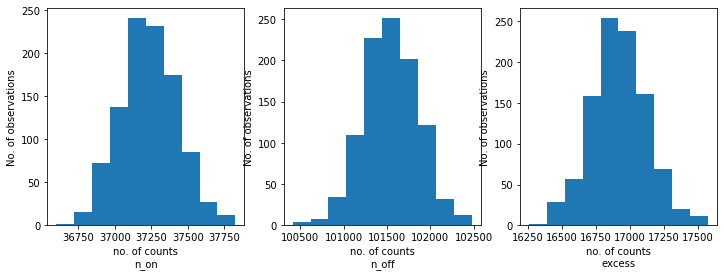

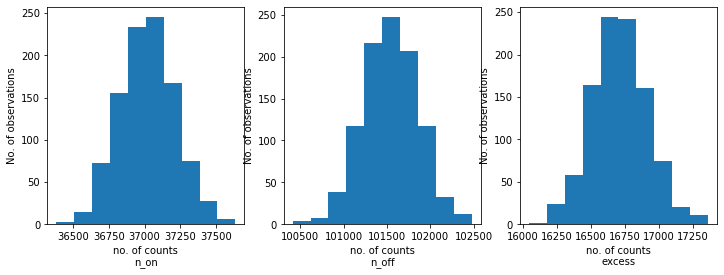

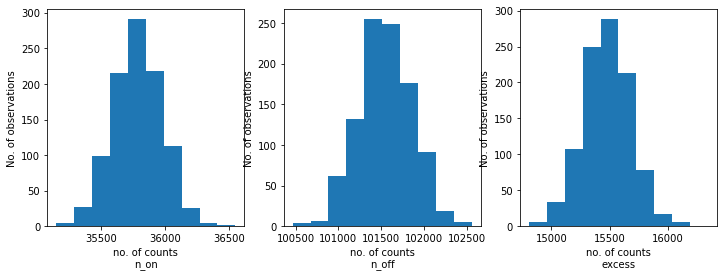

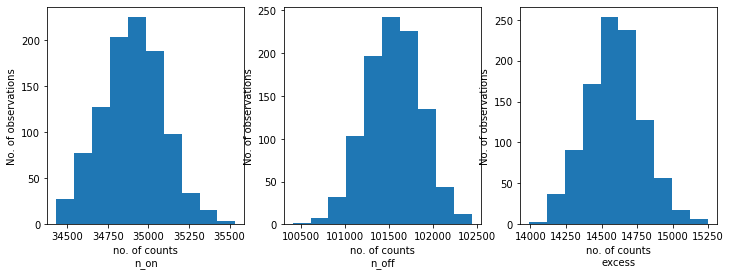

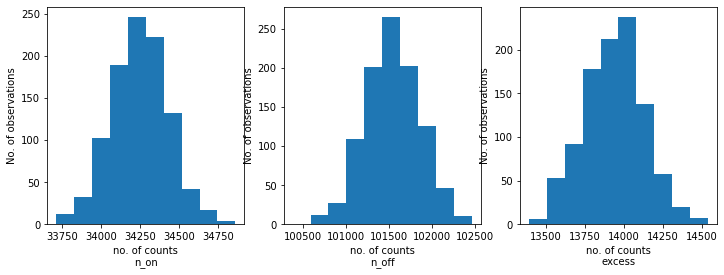

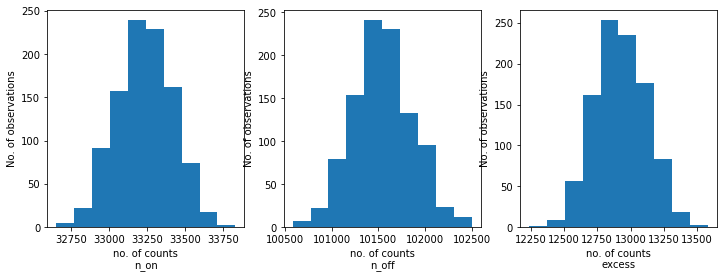

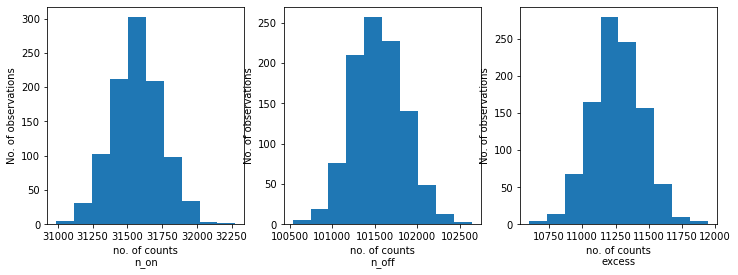

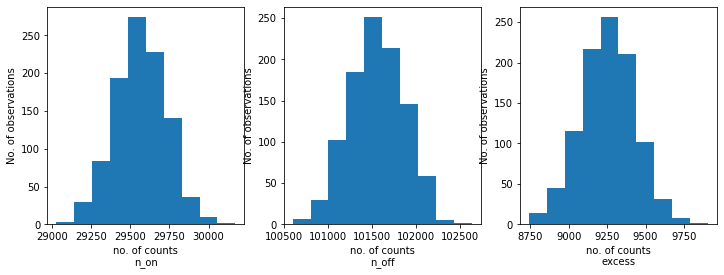

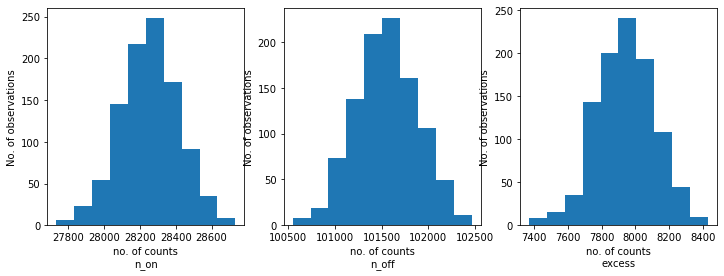

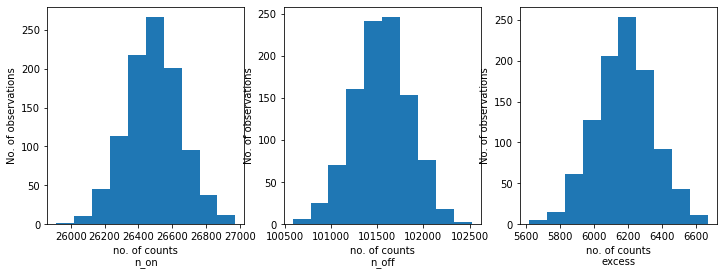

In [14]:
for i in range(10):
    n_on = [dataset.counts.data.sum() for dataset in datas[i]]
    n_off = [dataset.counts_off.data.sum() for dataset in datas[i]]
    excess = [dataset.excess.data.sum() for dataset in datas[i]]
    
    fix, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].hist(n_on)
    axes[0].set_xlabel("no. of counts\nn_on")
    axes[0].set_ylabel("No. of observations")
    axes[1].hist(n_off)
    axes[1].set_xlabel("no. of counts\nn_off")
    axes[1].set_ylabel("No. of observations")
    axes[2].hist(excess)
    axes[2].set_xlabel("no. of counts\nexcess");
    axes[2].set_ylabel("No. of observations")

In [15]:
%%time
res = []
results = []
for dataset in datas[0]:
    dataset.models = model[0].copy()
    fit = Fit([dataset])
    result = fit.optimize()
    results.append(
        {
            "index": result.parameters["index"].value,
            "amplitude": result.parameters["amplitude"].value,
            "reference":result.parameters["reference"].value,
        }
    )
    print(result.parameters.to_table())
res.append(results)

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.210e+00   nan                nan nan  False
amplitude 1.300e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.262e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.227e+00   nan                nan nan  False
amplitude 1.269e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.224e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.229e+00   nan                nan nan  False
amplitude 1.311e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.229e+00   nan                nan nan  False
amplitude 1.261e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.231e+00   nan                nan nan  False
amplitude 1.281e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.221e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.224e+00   nan                nan nan  False
amplitude 1.280e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.229e+00   nan                nan nan  False
amplitude 1.314e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.226e+00   nan                nan nan  False
amplitude 1.290e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.217e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.214e+00   nan                nan nan  False
amplitude 1.278e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.215e+00   nan                nan nan  False
amplitude 1.297e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.218e+00   nan                nan nan  False
amplitude 1.287e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.224e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.225e+00   nan                nan nan  False
amplitude 1.283e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.224e+00   nan                nan nan  False
amplitude 1.307e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.225e+00   nan                nan nan  False
amplitude 1.268e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.228e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.229e+00   nan                nan nan  False
amplitude 1.259e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.209e+00   nan                nan nan  False
amplitude 1.318e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.266e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.219e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.225e+00   nan                nan nan  False
amplitude 1.285e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.206e+00   nan                nan nan  False
amplitude 1.298e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.218e+00   nan                nan nan  False
amplitude 1.279e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.230e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.216e+00   nan                nan nan  False
amplitude 1.303e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.237e+00   nan                nan nan  False
amplitude 1.305e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.210e+00   nan                nan nan  False
amplitude 1.285e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.226e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.211e+00   nan                nan nan  False
amplitude 1.297e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.292e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.229e+00   nan                nan nan  False
amplitude 1.283e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.221e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.224e+00   nan                nan nan  False
amplitude 1.280e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.265e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.223e+00   nan                nan nan  False
amplitude 1.307e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.204e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.211e+00   nan                nan nan  False
amplitude 1.299e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.295e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.224e+00   nan                nan nan  False
amplitude 1.276e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.225e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.217e+00   nan                nan nan  False
amplitude 1.292e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.237e+00   nan                nan nan  False
amplitude 1.304e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.227e+00   nan                nan nan  False
amplitude 1.281e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.212e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.229e+00   nan                nan nan  False
amplitude 1.288e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.214e+00   nan                nan nan  False
amplitude 1.323e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.215e+00   nan                nan nan  False
amplitude 1.301e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.218e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.219e+00   nan                nan nan  False
amplitude 1.271e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.213e+00   nan                nan nan  False
amplitude 1.294e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.224e+00   nan                nan nan  False
amplitude 1.284e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.227e+00   nan                nan nan  False
amplitude 1.277e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.276e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.208e+00   nan                nan nan  False
amplitude 1.296e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.227e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.218e+00   nan                nan nan  False
amplitude 1.284e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.216e+00   nan                nan nan  False
amplitude 1.286e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.221e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.227e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.217e+00   nan                nan nan  False
amplitude 1.299e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.213e+00   nan                nan nan  False
amplitude 1.276e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.271e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.221e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.216e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.208e+00   nan                nan nan  False
amplitude 1.293e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.216e+00   nan                nan nan  False
amplitude 1.297e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.223e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.224e+00   nan                nan nan  False
amplitude 1.268e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.217e+00   nan                nan nan  False
amplitude 1.296e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.216e+00   nan                nan nan  False
amplitude 1.282e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.215e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.223e+00   nan                nan nan  False
amplitude 1.279e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.230e+00   nan                nan nan  False
amplitude 1.290e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.217e+00   nan                nan nan  False
amplitude 1.297e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.209e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.225e+00   nan                nan nan  False
amplitude 1.297e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.265e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.227e+00   nan                nan nan  False
amplitude 1.276e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.225e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.219e+00   nan                nan nan  False
amplitude 1.291e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.211e+00   nan                nan nan  False
amplitude 1.301e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.219e+00   nan                nan nan  False
amplitude 1.282e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.221e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.294e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.219e+00   nan                nan nan  False
amplitude 1.281e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.223e+00   nan                nan nan  False
amplitude 1.262e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.217e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.228e+00   nan                nan nan  False
amplitude 1.282e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.221e+00   nan                nan nan  False
amplitude 1.292e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.303e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.211e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.221e+00   nan                nan nan  False
amplitude 1.277e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.214e+00   nan                nan nan  False
amplitude 1.317e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.212e+00   nan                nan nan  False
amplitude 1.306e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.216e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.224e+00   nan                nan nan  False
amplitude 1.290e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.221e+00   nan                nan nan  False
amplitude 1.278e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.223e+00   nan                nan nan  False
amplitude 1.301e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.225e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.219e+00   nan                nan nan  False
amplitude 1.288e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.211e+00   nan                nan nan  False
amplitude 1.292e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.271e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.276e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.225e+00   nan                nan nan  False
amplitude 1.285e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.217e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.219e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.273e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.211e+00   nan                nan nan  False
amplitude 1.307e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.216e+00   nan                nan nan  False
amplitude 1.283e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.221e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.277e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.216e+00   nan                nan nan  False
amplitude 1.295e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.216e+00   nan                nan nan  False
amplitude 1.293e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.229e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.227e+00   nan                nan nan  False
amplitude 1.280e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.211e+00   nan                nan nan  False
amplitude 1.296e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.209e+00   nan                nan nan  False
amplitude 1.300e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.290e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.287e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.227e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.215e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.218e+00   nan                nan nan  False
amplitude 1.292e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.232e+00   nan                nan nan  False
amplitude 1.279e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.228e+00   nan                nan nan  False
amplitude 1.305e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.219e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.214e+00   nan                nan nan  False
amplitude 1.286e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.221e+00   nan                nan nan  False
amplitude 1.269e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.204e+00   nan                nan nan  False
amplitude 1.307e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.219e+00   nan                nan nan

In [16]:
for i in range(9):
    results = []
    for dataset in datas[i+1]:
        dataset.models = model[i+1].copy()
        fit = Fit([dataset])
        result = fit.optimize()
        results.append(
            {
                "index": result.parameters["index"].value,
                "amplitude": result.parameters["amplitude"].value,
                "lambda_": result.parameters["lambda_"].value,
                "reference":result.parameters["reference"].value,
                "alpha":result.parameters["alpha"].value,
            }
        )
        print(result.parameters.to_table())
    res.append(results)

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.203e+00   nan                nan nan  False
amplitude 1.319e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.335e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.217e+00   nan                nan nan  False
amplitude 1.273e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.248e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.234e+00   nan                nan nan  False
amplitude 1.256e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.229e+00   nan                nan nan  False
amplitude 1.251e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 8.252e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.218e+00   nan                nan nan  False
amplitude 1.278e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 8.381e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.216e+00   nan                nan nan  False
amplitude 1.303e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.282e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.711e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.204e+00   nan                nan nan  False
amplitude 1.283e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.201e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.215e+00   nan                nan nan  False
amplitude 1.297e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.223e+00   nan                nan nan  False
amplitude 1.268e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 7.301e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.218e+00   nan                nan nan  False
amplitude 1.294e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.053e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.276e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.216e+00   nan                nan nan  False
amplitude 1.279e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 6.831e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.207e+00   nan                nan nan  False
amplitude 1.318e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.439e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.212e+00   nan                nan nan  False
amplitude 1.292e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.224e+00   nan                nan nan  False
amplitude 1.271e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 7.195e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.231e+00   nan                nan nan  False
amplitude 1.273e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.696e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.203e+00   nan                nan nan  False
amplitude 1.295e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.210e+00   nan                nan nan  False
amplitude 1.312e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.471e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.200e+00   nan                nan nan  False
amplitude 1.303e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.256e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.224e+00   nan                nan nan  False
amplitude 1.291e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.225e+00   nan                nan nan  False
amplitude 1.262e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.063e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.205e+00   nan                nan nan  False
amplitude 1.305e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.222e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.230e+00   nan                nan nan  False
amplitude 1.292e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.229e+00   nan                nan nan  False
amplitude 1.299e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.976e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.225e+00   nan                nan nan  False
amplitude 1.282e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.186e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.204e+00   nan                nan nan  False
amplitude 1.324e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.228e+00   nan                nan nan  False
amplitude 1.285e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.026e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.219e+00   nan                nan nan  False
amplitude 1.284e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 6.840e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.206e+00   nan                nan nan  False
amplitude 1.277e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.219e+00   nan                nan nan  False
amplitude 1.297e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 8.467e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.243e+00   nan                nan nan  False
amplitude 1.290e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 6.710e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.214e+00   nan                nan nan  False
amplitude 1.277e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.237e+00   nan                nan nan  False
amplitude 1.262e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.329e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.234e+00   nan                nan nan  False
amplitude 1.274e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 8.461e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.277e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.205e+00   nan                nan nan  False
amplitude 1.305e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.415e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.215e+00   nan                nan nan  False
amplitude 1.267e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.637e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.226e+00   nan                nan nan  False
amplitude 1.281e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.209e+00   nan                nan nan  False
amplitude 1.283e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 7.463e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.211e+00   nan                nan nan  False
amplitude 1.317e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.684e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.210e+00   nan                nan nan  False
amplitude 1.283e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.221e+00   nan                nan nan  False
amplitude 1.282e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.099e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.218e+00   nan                nan nan  False
amplitude 1.314e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.169e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.226e+00   nan                nan nan  False
amplitude 1.299e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.231e+00   nan                nan nan  False
amplitude 1.267e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 6.370e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.221e+00   nan                nan nan  False
amplitude 1.282e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 7.990e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.286e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.221e+00   nan                nan nan  False
amplitude 1.305e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 8.011e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.221e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.019e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.201e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.217e+00   nan                nan nan  False
amplitude 1.311e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.357e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.297e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.207e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.219e+00   nan                nan nan  False
amplitude 1.277e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.209e+00   nan                nan nan  False
amplitude 1.307e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.294e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.218e+00   nan                nan nan  False
amplitude 1.302e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.025e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.223e+00   nan                nan nan  False
amplitude 1.258e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.200e+00   nan                nan nan  False
amplitude 1.307e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.095e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.225e+00   nan                nan nan  False
amplitude 1.292e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 6.841e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.228e+00   nan                nan nan  False
amplitude 1.276e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.229e+00   nan                nan nan  False
amplitude 1.274e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.320e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.278e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.038e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.203e+00   nan                nan nan  False
amplitude 1.305e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.281e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 8.319e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.216e+00   nan                nan nan  False
amplitude 1.300e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.196e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.295e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.236e+00   nan                nan nan  False
amplitude 1.262e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.759e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.228e+00   nan                nan nan  False
amplitude 1.278e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 6.545e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.231e+00   nan                nan nan  False
amplitude 1.260e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.210e+00   nan                nan nan  False
amplitude 1.291e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.484e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.237e+00   nan                nan nan  False
amplitude 1.275e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.210e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.214e+00   nan                nan nan  False
amplitude 1.309e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.202e+00   nan                nan nan  False
amplitude 1.325e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.630e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.217e+00   nan                nan nan  False
amplitude 1.284e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.424e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.302e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.304e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.019e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.202e+00   nan                nan nan  False
amplitude 1.293e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.359e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.225e+00   nan                nan nan  False
amplitude 1.294e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.207e+00   nan                nan nan  False
amplitude 1.305e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.430e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.224e+00   nan                nan nan  False
amplitude 1.282e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.155e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.208e+00   nan                nan nan  False
amplitude 1.309e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.218e+00   nan                nan nan  False
amplitude 1.308e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.674e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.230e+00   nan                nan nan  False
amplitude 1.290e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.252e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.212e+00   nan                nan nan  False
amplitude 1.329e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.223e+00   nan                nan nan  False
amplitude 1.278e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.105e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.282e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 7.059e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.212e+00   nan                nan nan  False
amplitude 1.310e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.211e+00   nan                nan nan  False
amplitude 1.307e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.203e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.210e+00   nan                nan nan  False
amplitude 1.294e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.057e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.219e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.217e+00   nan                nan nan  False
amplitude 1.287e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.000e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.215e+00   nan                nan nan  False
amplitude 1.271e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 8.558e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.218e+00   nan                nan nan  False
amplitude 1.292e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.296e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.060e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.198e+00   nan                nan nan  False
amplitude 1.303e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.374e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.227e+00   nan                nan nan  False
amplitude 1.275e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.226e+00   nan                nan nan  False
amplitude 1.293e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.371e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.215e+00   nan                nan nan  False
amplitude 1.280e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.225e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.217e+00   nan                nan nan  False
amplitude 1.300e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.293e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.026e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.223e+00   nan                nan nan  False
amplitude 1.297e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 8.811e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.199e+00   nan                nan nan  False
amplitude 1.343e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.221e+00   nan                nan nan  False
amplitude 1.240e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 6.313e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.292e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.063e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.235e+00   nan                nan nan  False
amplitude 1.256e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.235e+00   nan                nan nan  False
amplitude 1.268e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 6.461e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.235e+00   nan                nan nan  False
amplitude 1.265e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.917e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.215e+00   nan                nan nan  False
amplitude 1.281e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.204e+00   nan                nan nan  False
amplitude 1.302e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.213e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.226e+00   nan                nan nan  False
amplitude 1.292e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.049e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.219e+00   nan                nan nan  False
amplitude 1.278e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.217e+00   nan                nan nan  False
amplitude 1.278e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.126e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.228e+00   nan                nan nan  False
amplitude 1.279e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.111e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.224e+00   nan                nan nan  False
amplitude 1.306e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.227e+00   nan                nan nan  False
amplitude 1.268e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 7.777e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.235e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.204e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.211e+00   nan                nan nan  False
amplitude 1.316e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.211e+00   nan                nan nan  False
amplitude 1.303e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.254e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.228e+00   nan                nan nan  False
amplitude 1.285e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 8.071e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.231e+00   nan                nan nan  False
amplitude 1.259e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.205e+00   nan                nan nan  False
amplitude 1.295e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.140e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.214e+00   nan                nan nan  False
amplitude 1.311e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.233e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.221e+00   nan                nan nan  False
amplitude 1.292e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.226e+00   nan                nan nan  False
amplitude 1.295e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.592e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.291e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.099e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.211e+00   nan                nan nan  False
amplitude 1.317e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.219e+00   nan                nan nan  False
amplitude 1.314e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.255e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.216e+00   nan                nan nan  False
amplitude 1.295e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.062e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.280e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.215e+00   nan                nan nan  False
amplitude 1.304e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.576e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.203e+00   nan                nan nan  False
amplitude 1.312e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.341e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.205e+00   nan                nan nan  False
amplitude 1.308e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.224e+00   nan                nan nan  False
amplitude 1.279e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.086e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.210e+00   nan                nan nan  False
amplitude 1.315e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.600e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.225e+00   nan                nan nan  False
amplitude 1.284e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.225e+00   nan                nan nan  False
amplitude 1.280e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.654e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.210e+00   nan                nan nan  False
amplitude 1.315e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.073e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.211e+00   nan                nan nan  False
amplitude 1.295e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.215e+00   nan                nan nan  False
amplitude 1.320e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.170e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.208e+00   nan                nan nan  False
amplitude 1.316e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.679e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.216e+00   nan                nan nan  False
amplitude 1.288e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.310e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.200e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.223e+00   nan                nan nan  False
amplitude 1.269e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 7.975e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.214e+00   nan                nan nan  False
amplitude 1.282e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.210e+00   nan                nan nan  False
amplitude 1.305e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.027e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.226e+00   nan                nan nan  False
amplitude 1.263e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 8.531e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.231e+00   nan                nan nan  False
amplitude 1.257e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.204e+00   nan                nan nan  False
amplitude 1.349e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.214e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.239e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.344e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.238e+00   nan                nan nan  False
amplitude 1.247e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.217e+00   nan                nan nan  False
amplitude 1.278e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.721e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.212e+00   nan                nan nan  False
amplitude 1.279e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.025e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.205e+00   nan                nan nan  False
amplitude 1.308e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.316e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.118e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.227e+00   nan                nan nan  False
amplitude 1.268e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.918e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.214e+00   nan                nan nan  False
amplitude 1.295e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.230e+00   nan                nan nan  False
amplitude 1.283e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.764e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.224e+00   nan                nan nan  False
amplitude 1.293e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.011e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.216e+00   nan                nan nan  False
amplitude 1.303e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.228e+00   nan                nan nan  False
amplitude 1.294e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.210e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.236e+00   nan                nan nan  False
amplitude 1.281e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.591e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.228e+00   nan                nan nan  False
amplitude 1.292e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.234e+00   nan                nan nan  False
amplitude 1.280e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.042e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.225e+00   nan                nan nan  False
amplitude 1.293e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.028e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.219e+00   nan                nan nan  False
amplitude 1.270e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.235e+00   nan                nan nan  False
amplitude 1.238e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.083e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.213e+00   nan                nan nan  False
amplitude 1.295e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.077e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.218e+00   nan                nan nan  False
amplitude 1.311e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.225e+00   nan                nan nan  False
amplitude 1.274e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.296e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.209e+00   nan                nan nan  False
amplitude 1.311e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.038e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.256e+00   nan                nan nan  False
amplitude 1.220e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.231e+00   nan                nan nan  False
amplitude 1.268e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.031e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.185e+00   nan                nan nan  False
amplitude 1.343e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.196e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.198e+00   nan                nan nan  False
amplitude 1.347e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.236e+00   nan                nan nan  False
amplitude 1.275e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.767e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.204e+00   nan                nan nan  False
amplitude 1.356e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.314e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.216e+00   nan                nan nan  False
amplitude 1.284e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.216e+00   nan                nan nan  False
amplitude 1.295e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.511e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.215e+00   nan                nan nan  False
amplitude 1.287e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.524e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.208e+00   nan                nan nan  False
amplitude 1.306e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.219e+00   nan                nan nan  False
amplitude 1.276e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.566e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.221e+00   nan                nan nan  False
amplitude 1.303e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.094e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.236e+00   nan                nan nan  False
amplitude 1.253e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.199e+00   nan                nan nan  False
amplitude 1.301e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.107e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.214e+00   nan                nan nan  False
amplitude 1.305e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.056e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.228e+00   nan                nan nan  False
amplitude 1.278e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.214e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.023e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.224e+00   nan                nan nan  False
amplitude 1.275e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.018e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.313e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.218e+00   nan                nan nan  False
amplitude 1.268e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.614e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.203e+00   nan                nan nan  False
amplitude 1.287e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.035e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.233e+00   nan                nan nan  False
amplitude 1.278e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.234e+00   nan                nan nan  False
amplitude 1.251e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.412e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.239e+00   nan                nan nan  False
amplitude 1.237e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.164e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.304e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.227e+00   nan                nan nan  False
amplitude 1.275e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.902e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.219e+00   nan                nan nan  False
amplitude 1.301e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.089e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.203e+00   nan                nan nan  False
amplitude 1.331e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.214e+00   nan                nan nan  False
amplitude 1.303e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.086e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.217e+00   nan                nan nan  False
amplitude 1.279e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.055e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.218e+00   nan                nan nan  False
amplitude 1.281e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.235e+00   nan                nan nan  False
amplitude 1.264e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.465e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.211e+00   nan                nan nan  False
amplitude 1.326e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.109e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.209e+00   nan                nan nan  False
amplitude 1.321e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.216e+00   nan                nan nan  False
amplitude 1.296e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.097e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.233e+00   nan                nan nan  False
amplitude 1.269e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.523e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.238e+00   nan                nan nan  False
amplitude 1.255e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.207e+00   nan                nan nan  False
amplitude 1.331e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.064e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.211e+00   nan                nan nan  False
amplitude 1.320e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.030e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.297e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.209e+00   nan                nan nan  False
amplitude 1.308e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.009e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.200e+00   nan                nan nan  False
amplitude 1.327e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.064e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.225e+00   nan                nan nan  False
amplitude 1.286e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.214e+00   nan                nan nan  False
amplitude 1.284e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.059e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.217e+00   nan                nan nan  False
amplitude 1.271e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.065e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.215e+00   nan                nan nan  False
amplitude 1.312e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.263e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.058e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.204e+00   nan                nan nan  False
amplitude 1.326e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.099e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.235e+00   nan                nan nan  False
amplitude 1.233e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.213e+00   nan                nan nan  False
amplitude 1.304e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.021e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.209e+00   nan                nan nan  False
amplitude 1.329e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.159e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.199e+00   nan                nan nan  False
amplitude 1.331e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.221e+00   nan                nan nan  False
amplitude 1.283e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.995e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.223e+00   nan                nan nan  False
amplitude 1.322e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.075e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.224e+00   nan                nan nan  False
amplitude 1.293e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.212e+00   nan                nan nan  False
amplitude 1.270e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 8.552e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.236e+00   nan                nan nan  False
amplitude 1.255e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.038e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.218e+00   nan                nan nan  False
amplitude 1.295e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.215e+00   nan                nan nan  False
amplitude 1.288e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.774e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.226e+00   nan                nan nan  False
amplitude 1.276e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.105e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.197e+00   nan                nan nan  False
amplitude 1.347e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.226e+00   nan                nan nan  False
amplitude 1.269e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.267e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.218e+00   nan                nan nan  False
amplitude 1.333e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.050e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.213e+00   nan                nan nan  False
amplitude 1.305e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.311e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.086e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.230e+00   nan                nan nan  False
amplitude 1.284e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 8.537e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.240e+00   nan                nan nan  False
amplitude 1.257e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.221e+00   nan                nan nan  False
amplitude 1.287e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.727e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.225e+00   nan                nan nan  False
amplitude 1.315e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.026e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.232e+00   nan                nan nan  False
amplitude 1.275e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.201e+00   nan                nan nan  False
amplitude 1.302e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.063e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.216e+00   nan                nan nan  False
amplitude 1.309e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.026e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.225e+00   nan                nan nan  False
amplitude 1.261e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.252e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 8.929e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.216e+00   nan                nan nan  False
amplitude 1.265e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.544e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.223e+00   nan                nan nan  False
amplitude 1.279e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.223e+00   nan                nan nan  False
amplitude 1.257e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.637e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.225e+00   nan                nan nan  False
amplitude 1.288e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.076e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.241e+00   nan                nan nan  False
amplitude 1.237e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.233e+00   nan                nan nan  False
amplitude 1.274e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.181e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.238e+00   nan                nan nan  False
amplitude 1.252e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 8.533e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.221e+00   nan                nan nan  False
amplitude 1.309e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.237e+00   nan                nan nan  False
amplitude 1.290e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.871e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.202e+00   nan                nan nan  False
amplitude 1.311e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.104e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.272e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.213e+00   nan                nan nan  False
amplitude 1.293e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.092e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.216e+00   nan                nan nan  False
amplitude 1.331e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.064e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.216e+00   nan                nan nan  False
amplitude 1.327e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.227e+00   nan                nan nan  False
amplitude 1.298e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.509e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.232e+00   nan                nan nan  False
amplitude 1.262e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.216e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.234e+00   nan                nan nan  False
amplitude 1.274e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.208e+00   nan                nan nan  False
amplitude 1.307e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.036e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.207e+00   nan                nan nan  False
amplitude 1.320e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.156e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.218e+00   nan                nan nan  False
amplitude 1.281e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.225e+00   nan                nan nan  False
amplitude 1.288e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.062e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.227e+00   nan                nan nan  False
amplitude 1.254e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.665e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.214e+00   nan                nan nan  False
amplitude 1.292e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.211e+00   nan                nan nan  False
amplitude 1.276e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.045e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.253e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.862e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.237e+00   nan                nan nan  False
amplitude 1.257e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.212e+00   nan                nan nan  False
amplitude 1.297e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.015e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.212e+00   nan                nan nan  False
amplitude 1.273e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.155e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.229e+00   nan                nan nan  False
amplitude 1.252e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.217e+00   nan                nan nan  False
amplitude 1.296e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.688e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.230e+00   nan                nan nan  False
amplitude 1.278e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.333e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.221e+00   nan                nan nan  False
amplitude 1.313e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.231e+00   nan                nan nan  False
amplitude 1.258e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.611e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.227e+00   nan                nan nan  False
amplitude 1.269e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.504e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.227e+00   nan                nan nan  False
amplitude 1.293e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.221e+00   nan                nan nan  False
amplitude 1.270e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.450e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.231e+00   nan                nan nan  False
amplitude 1.274e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 8.396e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.224e+00   nan                nan nan  False
amplitude 1.285e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.219e+00   nan                nan nan  False
amplitude 1.286e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.987e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.204e+00   nan                nan nan  False
amplitude 1.305e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.101e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.227e+00   nan                nan nan  False
amplitude 1.282e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.223e+00   nan                nan nan  False
amplitude 1.265e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.917e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.212e+00   nan                nan nan  False
amplitude 1.282e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.270e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.213e+00   nan                nan nan  False
amplitude 1.301e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.226e+00   nan                nan nan  False
amplitude 1.269e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.930e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.243e+00   nan                nan nan  False
amplitude 1.230e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.813e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.227e+00   nan                nan nan  False
amplitude 1.300e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.235e+00   nan                nan nan  False
amplitude 1.220e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.795e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.230e+00   nan                nan nan  False
amplitude 1.282e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.016e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.225e+00   nan                nan nan  False
amplitude 1.295e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.213e+00   nan                nan nan  False
amplitude 1.290e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.030e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.223e+00   nan                nan nan  False
amplitude 1.292e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.081e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.205e+00   nan                nan nan  False
amplitude 1.320e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.205e+00   nan                nan nan  False
amplitude 1.341e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.115e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.288e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.965e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.236e+00   nan                nan nan  False
amplitude 1.274e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.230e+00   nan                nan nan  False
amplitude 1.265e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.853e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.271e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.888e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.221e+00   nan                nan nan  False
amplitude 1.272e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.198e+00   nan                nan nan  False
amplitude 1.368e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.188e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.202e+00   nan                nan nan  False
amplitude 1.342e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.343e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.226e+00   nan                nan nan  False
amplitude 1.285e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.226e+00   nan                nan nan  False
amplitude 1.302e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.987e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.236e+00   nan                nan nan  False
amplitude 1.208e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.766e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.217e+00   nan                nan nan  False
amplitude 1.290e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.243e+00   nan                nan nan  False
amplitude 1.244e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.821e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.238e+00   nan                nan nan  False
amplitude 1.254e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.902e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.219e+00   nan                nan nan  False
amplitude 1.309e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.213e+00   nan                nan nan  False
amplitude 1.301e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.029e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.283e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.890e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.225e+00   nan                nan nan  False
amplitude 1.301e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.245e+00   nan                nan nan  False
amplitude 1.238e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.852e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.215e+00   nan                nan nan  False
amplitude 1.292e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.997e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.217e+00   nan                nan nan  False
amplitude 1.299e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.228e+00   nan                nan nan  False
amplitude 1.268e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.993e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.234e+00   nan                nan nan  False
amplitude 1.240e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.846e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.219e+00   nan                nan nan  False
amplitude 1.290e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.193e+00   nan                nan nan  False
amplitude 1.351e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.182e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.216e+00   nan                nan nan  False
amplitude 1.295e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.935e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.216e+00   nan                nan nan  False
amplitude 1.307e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.229e+00   nan                nan nan  False
amplitude 1.273e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.009e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.212e+00   nan                nan nan  False
amplitude 1.294e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.990e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.253e+00   nan                nan nan  False
amplitude 1.204e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.224e+00   nan                nan nan  False
amplitude 1.265e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.969e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.234e+00   nan                nan nan  False
amplitude 1.252e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.910e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.227e+00   nan                nan nan  False
amplitude 1.276e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.283e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.951e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.205e+00   nan                nan nan  False
amplitude 1.307e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.142e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.238e+00   nan                nan nan  False
amplitude 1.263e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.216e+00   nan                nan nan  False
amplitude 1.360e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.227e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.214e+00   nan                nan nan  False
amplitude 1.318e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.341e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.234e+00   nan                nan nan  False
amplitude 1.225e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.263e+00   nan                nan nan  False
amplitude 1.205e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.735e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.221e+00   nan                nan nan  False
amplitude 1.260e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.032e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.216e+00   nan                nan nan  False
amplitude 1.336e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.298e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.996e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.233e+00   nan                nan nan  False
amplitude 1.244e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.836e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.165e+00   nan                nan nan  False
amplitude 1.397e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.189e+00   nan                nan nan  False
amplitude 1.363e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.138e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.227e+00   nan                nan nan  False
amplitude 1.277e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.110e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.246e+00   nan                nan nan  False
amplitude 1.246e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.199e+00   nan                nan nan  False
amplitude 1.307e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.955e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.219e+00   nan                nan nan  False
amplitude 1.314e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.126e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.199e+00   nan                nan nan  False
amplitude 1.312e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.278e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.853e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.229e+00   nan                nan nan  False
amplitude 1.248e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.941e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.223e+00   nan                nan nan  False
amplitude 1.285e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.206e+00   nan                nan nan  False
amplitude 1.337e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.989e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.190e+00   nan                nan nan  False
amplitude 1.351e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.172e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.234e+00   nan                nan nan  False
amplitude 1.241e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.224e+00   nan                nan nan  False
amplitude 1.257e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.915e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.216e+00   nan                nan nan  False
amplitude 1.307e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.129e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.221e+00   nan                nan nan  False
amplitude 1.291e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.233e+00   nan                nan nan  False
amplitude 1.260e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.931e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.231e+00   nan                nan nan  False
amplitude 1.270e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.898e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.218e+00   nan                nan nan  False
amplitude 1.272e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.233e+00   nan                nan nan  False
amplitude 1.242e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.019e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.275e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.886e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.197e+00   nan                nan nan  False
amplitude 1.321e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.209e+00   nan                nan nan  False
amplitude 1.354e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.360e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.201e+00   nan                nan nan  False
amplitude 1.335e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.142e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.206e+00   nan                nan nan  False
amplitude 1.310e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.215e+00   nan                nan nan  False
amplitude 1.271e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.061e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.215e+00   nan                nan nan  False
amplitude 1.316e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.086e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.231e+00   nan                nan nan  False
amplitude 1.273e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.232e+00   nan                nan nan  False
amplitude 1.271e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.034e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.225e+00   nan                nan nan  False
amplitude 1.233e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.874e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.229e+00   nan                nan nan  False
amplitude 1.307e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.294e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.085e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.221e+00   nan                nan nan  False
amplitude 1.286e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.940e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.224e+00   nan                nan nan  False
amplitude 1.305e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.211e+00   nan                nan nan  False
amplitude 1.267e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.045e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.226e+00   nan                nan nan  False
amplitude 1.252e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.936e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.202e+00   nan                nan nan  False
amplitude 1.339e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.198e+00   nan                nan nan  False
amplitude 1.312e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.069e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.230e+00   nan                nan nan  False
amplitude 1.258e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.911e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.216e+00   nan                nan nan  False
amplitude 1.323e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.241e+00   nan                nan nan  False
amplitude 1.247e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.862e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.243e+00   nan                nan nan  False
amplitude 1.222e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.722e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.242e+00   nan                nan nan  False
amplitude 1.244e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.215e+00   nan                nan nan  False
amplitude 1.302e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.036e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.205e+00   nan                nan nan  False
amplitude 1.334e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.104e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.288e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.215e+00   nan                nan nan  False
amplitude 1.299e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.068e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.224e+00   nan                nan nan  False
amplitude 1.295e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.001e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.237e+00   nan                nan nan  False
amplitude 1.235e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.245e+00   nan                nan nan  False
amplitude 1.226e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.783e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.242e+00   nan                nan nan  False
amplitude 1.213e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.750e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.224e+00   nan                nan nan  False
amplitude 1.277e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.236e+00   nan                nan nan  False
amplitude 1.275e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.788e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.225e+00   nan                nan nan  False
amplitude 1.236e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.864e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.217e+00   nan                nan nan  False
amplitude 1.291e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.233e+00   nan                nan nan  False
amplitude 1.267e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.038e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.238e+00   nan                nan nan  False
amplitude 1.260e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.629e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.225e+00   nan                nan nan  False
amplitude 1.299e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.219e+00   nan                nan nan  False
amplitude 1.286e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.972e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.219e+00   nan                nan nan  False
amplitude 1.275e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.868e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.206e+00   nan                nan nan  False
amplitude 1.320e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.189e+00   nan                nan nan  False
amplitude 1.398e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.382e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.215e+00   nan                nan nan  False
amplitude 1.296e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.028e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.240e+00   nan                nan nan  False
amplitude 1.251e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.225e+00   nan                nan nan  False
amplitude 1.302e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.067e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.250e+00   nan                nan nan  False
amplitude 1.266e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.827e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.306e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.253e+00   nan                nan nan  False
amplitude 1.255e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.784e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.213e+00   nan                nan nan  False
amplitude 1.290e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.068e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.186e+00   nan                nan nan  False
amplitude 1.375e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.214e+00   nan                nan nan  False
amplitude 1.290e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.062e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.212e+00   nan                nan nan  False
amplitude 1.271e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.962e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.214e+00   nan                nan nan  False
amplitude 1.310e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.224e+00   nan                nan nan  False
amplitude 1.274e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.956e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.282e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.040e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.232e+00   nan                nan nan  False
amplitude 1.286e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.209e+00   nan                nan nan  False
amplitude 1.293e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.046e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.219e+00   nan                nan nan  False
amplitude 1.310e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.062e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.219e+00   nan                nan nan  False
amplitude 1.328e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.223e+00   nan                nan nan  False
amplitude 1.258e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.995e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.238e+00   nan                nan nan  False
amplitude 1.245e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.909e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.198e+00   nan                nan nan  False
amplitude 1.315e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.215e+00   nan                nan nan  False
amplitude 1.321e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.138e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.228e+00   nan                nan nan  False
amplitude 1.261e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.900e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.186e+00   nan                nan nan  False
amplitude 1.345e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.191e+00   nan                nan nan  False
amplitude 1.334e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.207e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.218e+00   nan                nan nan  False
amplitude 1.273e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.866e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.213e+00   nan                nan nan  False
amplitude 1.290e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.226e+00   nan                nan nan  False
amplitude 1.262e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.024e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.239e+00   nan                nan nan  False
amplitude 1.277e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.067e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.199e+00   nan                nan nan  False
amplitude 1.330e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.232e+00   nan                nan nan  False
amplitude 1.259e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.783e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.215e+00   nan                nan nan  False
amplitude 1.296e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.014e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.211e+00   nan                nan nan  False
amplitude 1.342e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.211e+00   nan                nan nan  False
amplitude 1.280e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.898e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.246e+00   nan                nan nan  False
amplitude 1.212e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.681e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.210e+00   nan                nan nan  False
amplitude 1.354e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.197e+00   nan                nan nan  False
amplitude 1.353e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.570e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.209e+00   nan                nan nan  False
amplitude 1.306e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.044e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.211e+00   nan                nan nan  False
amplitude 1.319e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.210e+00   nan                nan nan  False
amplitude 1.324e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.024e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.210e+00   nan                nan nan  False
amplitude 1.320e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.102e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.242e+00   nan                nan nan  False
amplitude 1.248e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.197e+00   nan                nan nan  False
amplitude 1.353e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.212e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.229e+00   nan                nan nan  False
amplitude 1.308e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.204e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.172e+00   nan                nan nan  False
amplitude 1.415e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.254e+00   nan                nan nan  False
amplitude 1.216e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.558e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.212e+00   nan                nan nan  False
amplitude 1.310e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.074e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.197e+00   nan                nan nan  False
amplitude 1.391e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.254e+00   nan                nan nan  False
amplitude 1.200e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.405e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.212e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.088e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.207e+00   nan                nan nan  False
amplitude 1.311e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.180e+00   nan                nan nan  False
amplitude 1.353e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.404e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.217e+00   nan                nan nan  False
amplitude 1.293e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.212e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.195e+00   nan                nan nan  False
amplitude 1.352e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.225e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.918e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.218e+00   nan                nan nan  False
amplitude 1.275e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.911e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.237e+00   nan                nan nan  False
amplitude 1.246e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.215e+00   nan                nan nan  False
amplitude 1.303e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.199e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.199e+00   nan                nan nan  False
amplitude 1.321e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.998e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.235e+00   nan                nan nan  False
amplitude 1.250e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.240e+00   nan                nan nan  False
amplitude 1.235e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.834e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.182e+00   nan                nan nan  False
amplitude 1.378e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.449e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.228e+00   nan                nan nan  False
amplitude 1.266e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.196e+00   nan                nan nan  False
amplitude 1.322e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.136e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.253e+00   nan                nan nan  False
amplitude 1.233e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.793e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.178e+00   nan                nan nan  False
amplitude 1.371e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.163e+00   nan                nan nan  False
amplitude 1.387e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.380e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.208e+00   nan                nan nan  False
amplitude 1.341e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.231e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.218e+00   nan                nan nan  False
amplitude 1.299e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.232e+00   nan                nan nan  False
amplitude 1.247e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.741e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.208e+00   nan                nan nan  False
amplitude 1.333e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.160e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.203e+00   nan                nan nan  False
amplitude 1.306e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.212e+00   nan                nan nan  False
amplitude 1.300e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.012e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.258e+00   nan                nan nan  False
amplitude 1.224e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.675e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.259e+00   nan                nan nan  False
amplitude 1.197e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.290e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.195e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.240e+00   nan                nan nan  False
amplitude 1.255e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.942e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.219e+00   nan                nan nan  False
amplitude 1.315e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.228e+00   nan                nan nan  False
amplitude 1.293e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.825e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.209e+00   nan                nan nan  False
amplitude 1.322e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.023e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.195e+00   nan                nan nan  False
amplitude 1.345e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.198e+00   nan                nan nan  False
amplitude 1.358e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.410e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.239e+00   nan                nan nan  False
amplitude 1.222e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.722e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.211e+00   nan                nan nan  False
amplitude 1.310e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.200e+00   nan                nan nan  False
amplitude 1.321e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.233e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.232e+00   nan                nan nan  False
amplitude 1.292e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.950e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.212e+00   nan                nan nan  False
amplitude 1.301e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.235e+00   nan                nan nan  False
amplitude 1.267e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.034e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.254e+00   nan                nan nan  False
amplitude 1.217e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.638e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.239e+00   nan                nan nan  False
amplitude 1.234e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.175e+00   nan                nan nan  False
amplitude 1.436e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.684e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.232e+00   nan                nan nan  False
amplitude 1.258e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.989e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.224e+00   nan                nan nan  False
amplitude 1.284e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.214e+00   nan                nan nan  False
amplitude 1.279e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.780e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.246e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.937e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.234e+00   nan                nan nan  False
amplitude 1.263e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.203e+00   nan                nan nan  False
amplitude 1.368e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.279e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.301e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.090e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.200e+00   nan                nan nan  False
amplitude 1.343e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.234e+00   nan                nan nan  False
amplitude 1.279e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.810e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.227e+00   nan                nan nan  False
amplitude 1.300e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.330e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.237e+00   nan                nan nan  False
amplitude 1.247e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.209e+00   nan                nan nan  False
amplitude 1.365e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.360e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.215e+00   nan                nan nan  False
amplitude 1.313e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.179e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.232e+00   nan                nan nan  False
amplitude 1.297e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.223e+00   nan                nan nan  False
amplitude 1.268e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.947e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.231e+00   nan                nan nan  False
amplitude 1.273e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.934e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.211e+00   nan                nan nan  False
amplitude 1.316e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.218e+00   nan                nan nan  False
amplitude 1.265e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.938e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.237e+00   nan                nan nan  False
amplitude 1.250e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.727e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.212e+00   nan                nan nan  False
amplitude 1.342e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.216e+00   nan                nan nan  False
amplitude 1.302e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.848e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.193e+00   nan                nan nan  False
amplitude 1.381e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.705e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.218e+00   nan                nan nan  False
amplitude 1.272e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.198e+00   nan                nan nan  False
amplitude 1.347e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.384e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.210e+00   nan                nan nan  False
amplitude 1.322e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.154e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.231e+00   nan                nan nan  False
amplitude 1.291e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.247e+00   nan                nan nan  False
amplitude 1.221e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.685e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.207e+00   nan                nan nan  False
amplitude 1.323e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.997e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.246e+00   nan                nan nan  False
amplitude 1.261e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.201e+00   nan                nan nan  False
amplitude 1.366e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.308e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.202e+00   nan                nan nan  False
amplitude 1.316e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.069e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.241e+00   nan                nan nan  False
amplitude 1.208e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.238e+00   nan                nan nan  False
amplitude 1.240e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.566e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.218e+00   nan                nan nan  False
amplitude 1.306e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.099e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.194e+00   nan                nan nan  False
amplitude 1.370e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.171e+00   nan                nan nan  False
amplitude 1.417e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.503e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.275e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.848e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.245e+00   nan                nan nan  False
amplitude 1.251e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.200e+00   nan                nan nan  False
amplitude 1.331e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.209e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.288e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.828e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.204e+00   nan                nan nan  False
amplitude 1.329e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.242e+00   nan                nan nan  False
amplitude 1.227e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.581e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.229e+00   nan                nan nan  False
amplitude 1.273e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.885e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.263e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.192e+00   nan                nan nan  False
amplitude 1.356e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.330e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.239e+00   nan                nan nan  False
amplitude 1.228e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.889e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.228e+00   nan                nan nan  False
amplitude 1.250e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.248e+00   nan                nan nan  False
amplitude 1.230e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.855e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.231e+00   nan                nan nan  False
amplitude 1.246e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.877e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.247e+00   nan                nan nan  False
amplitude 1.218e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.234e+00   nan                nan nan  False
amplitude 1.257e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.760e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.229e+00   nan                nan nan  False
amplitude 1.269e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.910e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.260e+00   nan                nan nan  False
amplitude 1.191e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.323e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.135e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.236e+00   nan                nan nan  False
amplitude 1.259e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.777e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.243e+00   nan                nan nan  False
amplitude 1.246e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.285e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.886e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.238e+00   nan                nan nan  False
amplitude 1.253e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.917e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.203e+00   nan                nan nan  False
amplitude 1.346e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.199e+00   nan                nan nan  False
amplitude 1.317e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.243e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.206e+00   nan                nan nan  False
amplitude 1.329e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.070e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.201e+00   nan                nan nan  False
amplitude 1.317e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.189e+00   nan                nan nan  False
amplitude 1.367e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.142e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.188e+00   nan                nan nan  False
amplitude 1.380e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.207e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.238e+00   nan                nan nan  False
amplitude 1.236e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.209e+00   nan                nan nan  False
amplitude 1.338e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.363e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.248e+00   nan                nan nan  False
amplitude 1.209e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.500e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.275e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.230e+00   nan                nan nan  False
amplitude 1.276e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.005e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.203e+00   nan                nan nan  False
amplitude 1.317e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.128e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.255e+00   nan                nan nan  False
amplitude 1.211e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.198e+00   nan                nan nan  False
amplitude 1.338e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.078e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.209e+00   nan                nan nan  False
amplitude 1.273e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.815e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.211e+00   nan                nan nan  False
amplitude 1.297e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.304e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.009e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.252e+00   nan                nan nan  False
amplitude 1.192e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.569e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.214e+00   nan                nan nan  False
amplitude 1.322e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.231e+00   nan                nan nan  False
amplitude 1.306e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.678e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.200e+00   nan                nan nan  False
amplitude 1.357e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.169e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.203e+00   nan                nan nan  False
amplitude 1.330e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.196e+00   nan                nan nan  False
amplitude 1.323e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.831e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.223e+00   nan                nan nan  False
amplitude 1.284e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.248e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.246e+00   nan                nan nan  False
amplitude 1.240e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.240e+00   nan                nan nan  False
amplitude 1.259e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.891e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.243e+00   nan                nan nan  False
amplitude 1.244e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.563e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.200e+00   nan                nan nan  False
amplitude 1.331e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.196e+00   nan                nan nan  False
amplitude 1.344e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.312e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.186e+00   nan                nan nan  False
amplitude 1.390e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.675e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.214e+00   nan                nan nan  False
amplitude 1.296e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.219e+00   nan                nan nan  False
amplitude 1.276e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.965e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.221e+00   nan                nan nan  False
amplitude 1.270e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.876e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.259e+00   nan                nan nan  False
amplitude 1.154e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.209e+00   nan                nan nan  False
amplitude 1.338e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.402e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.192e+00   nan                nan nan  False
amplitude 1.356e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.642e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.171e+00   nan                nan nan  False
amplitude 1.417e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.202e+00   nan                nan nan  False
amplitude 1.324e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.100e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.254e+00   nan                nan nan  False
amplitude 1.196e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.466e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.262e+00   nan                nan nan  False
amplitude 1.196e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.236e+00   nan                nan nan  False
amplitude 1.290e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.001e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.242e+00   nan                nan nan  False
amplitude 1.229e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.986e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.199e+00   nan                nan nan  False
amplitude 1.350e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.211e+00   nan                nan nan  False
amplitude 1.297e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.252e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.240e+00   nan                nan nan  False
amplitude 1.235e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.618e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.231e+00   nan                nan nan  False
amplitude 1.273e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.221e+00   nan                nan nan  False
amplitude 1.309e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.010e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.201e+00   nan                nan nan  False
amplitude 1.307e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.054e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.194e+00   nan                nan nan  False
amplitude 1.370e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.209e+00   nan                nan nan  False
amplitude 1.316e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.307e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.207e+00   nan                nan nan  False
amplitude 1.341e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.523e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.247e+00   nan                nan nan  False
amplitude 1.213e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.211e+00   nan                nan nan  False
amplitude 1.281e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.865e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.212e+00   nan                nan nan  False
amplitude 1.308e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.291e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.291e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.219e+00   nan                nan nan  False
amplitude 1.333e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.339e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.207e+00   nan                nan nan  False
amplitude 1.297e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.018e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.189e+00   nan                nan nan  False
amplitude 1.390e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.216e+00   nan                nan nan  False
amplitude 1.337e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.316e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.212e+00   nan                nan nan  False
amplitude 1.313e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.971e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.183e+00   nan                nan nan  False
amplitude 1.398e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.184e+00   nan                nan nan  False
amplitude 1.385e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.571e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.179e+00   nan                nan nan  False
amplitude 1.400e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.473e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.159e+00   nan                nan nan  False
amplitude 1.453e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.194e+00   nan                nan nan  False
amplitude 1.384e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.328e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.228e+00   nan                nan nan  False
amplitude 1.255e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.631e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.190e+00   nan                nan nan  False
amplitude 1.400e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.210e+00   nan                nan nan  False
amplitude 1.307e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.024e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.162e+00   nan                nan nan  False
amplitude 1.453e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.703e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.197e+00   nan                nan nan  False
amplitude 1.341e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.191e+00   nan                nan nan  False
amplitude 1.372e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.779e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.213e+00   nan                nan nan  False
amplitude 1.325e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.046e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.225e+00   nan                nan nan  False
amplitude 1.299e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.240e+00   nan                nan nan  False
amplitude 1.266e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.997e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.253e+00   nan                nan nan  False
amplitude 1.182e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.251e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.202e+00   nan                nan nan  False
amplitude 1.326e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.209e+00   nan                nan nan  False
amplitude 1.314e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.105e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.236e+00   nan                nan nan  False
amplitude 1.211e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.521e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.228e+00   nan                nan nan  False
amplitude 1.279e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.302e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.706e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.224e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.946e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.199e+00   nan                nan nan  False
amplitude 1.327e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.224e+00   nan                nan nan  False
amplitude 1.283e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.897e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.217e+00   nan                nan nan  False
amplitude 1.310e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.296e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.170e+00   nan                nan nan  False
amplitude 1.438e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.286e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.972e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.226e+00   nan                nan nan  False
amplitude 1.321e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.174e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.232e+00   nan                nan nan  False
amplitude 1.213e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.192e+00   nan                nan nan  False
amplitude 1.363e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.347e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.249e+00   nan                nan nan  False
amplitude 1.200e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.837e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.237e+00   nan                nan nan  False
amplitude 1.236e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.203e+00   nan                nan nan  False
amplitude 1.374e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.495e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.211e+00   nan                nan nan  False
amplitude 1.323e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.136e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.185e+00   nan                nan nan  False
amplitude 1.370e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.231e+00   nan                nan nan  False
amplitude 1.261e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.888e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.225e+00   nan                nan nan  False
amplitude 1.282e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.812e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.186e+00   nan                nan nan  False
amplitude 1.390e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.251e+00   nan                nan nan  False
amplitude 1.214e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.499e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.242e+00   nan                nan nan  False
amplitude 1.233e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.741e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.184e+00   nan                nan nan  False
amplitude 1.369e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.212e+00   nan                nan nan  False
amplitude 1.313e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.335e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.228e+00   nan                nan nan  False
amplitude 1.282e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.943e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.249e+00   nan                nan nan  False
amplitude 1.214e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.218e+00   nan                nan nan  False
amplitude 1.294e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.173e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.237e+00   nan                nan nan  False
amplitude 1.246e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.915e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.242e+00   nan                nan nan  False
amplitude 1.198e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.199e+00   nan                nan nan  False
amplitude 1.395e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.978e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.247e+00   nan                nan nan  False
amplitude 1.217e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.637e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.168e+00   nan                nan nan  False
amplitude 1.407e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.215e+00   nan                nan nan  False
amplitude 1.294e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.008e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.219e+00   nan                nan nan  False
amplitude 1.286e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.017e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.230e+00   nan                nan nan  False
amplitude 1.276e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.173e+00   nan                nan nan  False
amplitude 1.368e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.389e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.237e+00   nan                nan nan  False
amplitude 1.229e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.722e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.276e+00   nan                nan nan  False
amplitude 1.127e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.242e+00   nan                nan nan  False
amplitude 1.233e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.750e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.213e+00   nan                nan nan  False
amplitude 1.310e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.239e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.243e+00   nan                nan nan  False
amplitude 1.216e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.209e+00   nan                nan nan  False
amplitude 1.320e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.079e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.288e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.034e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.188e+00   nan                nan nan  False
amplitude 1.359e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.252e+00   nan                nan nan  False
amplitude 1.192e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.711e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.219e+00   nan                nan nan  False
amplitude 1.288e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.125e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.237e+00   nan                nan nan  False
amplitude 1.218e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.200e+00   nan                nan nan  False
amplitude 1.301e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.916e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.157e+00   nan                nan nan  False
amplitude 1.452e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 6.071e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.253e+00   nan                nan nan  False
amplitude 1.206e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.213e+00   nan                nan nan  False
amplitude 1.303e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.793e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.247e+00   nan                nan nan  False
amplitude 1.220e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.454e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.266e+00   nan                nan nan  False
amplitude 1.141e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.224e+00   nan                nan nan  False
amplitude 1.238e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.098e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.207e+00   nan                nan nan  False
amplitude 1.296e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.997e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.239e+00   nan                nan nan  False
amplitude 1.254e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.231e+00   nan                nan nan  False
amplitude 1.249e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.809e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.237e+00   nan                nan nan  False
amplitude 1.255e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.795e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.246e+00   nan                nan nan  False
amplitude 1.236e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.253e+00   nan                nan nan  False
amplitude 1.218e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.644e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.198e+00   nan                nan nan  False
amplitude 1.357e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.270e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.189e+00   nan                nan nan  False
amplitude 1.382e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.223e+00   nan                nan nan  False
amplitude 1.303e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.061e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.223e+00   nan                nan nan  False
amplitude 1.321e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.149e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.262e+00   nan                nan nan  False
amplitude 1.187e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.195e+00   nan                nan nan  False
amplitude 1.362e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.551e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.251e+00   nan                nan nan  False
amplitude 1.221e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.552e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.186e+00   nan                nan nan  False
amplitude 1.372e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.193e+00   nan                nan nan  False
amplitude 1.323e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.137e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.267e+00   nan                nan nan  False
amplitude 1.156e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.151e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.236e+00   nan                nan nan  False
amplitude 1.296e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.262e+00   nan                nan nan  False
amplitude 1.181e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.406e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.204e+00   nan                nan nan  False
amplitude 1.375e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.512e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.191e+00   nan                nan nan  False
amplitude 1.390e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.224e+00   nan                nan nan  False
amplitude 1.271e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.065e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.241e+00   nan                nan nan  False
amplitude 1.287e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.760e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.205e+00   nan                nan nan  False
amplitude 1.372e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.237e+00   nan                nan nan  False
amplitude 1.250e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.715e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.226e+00   nan                nan nan  False
amplitude 1.304e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.281e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.244e+00   nan                nan nan  False
amplitude 1.199e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.201e+00   nan                nan nan  False
amplitude 1.374e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.241e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.203e+00   nan                nan nan  False
amplitude 1.304e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.298e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.231e+00   nan                nan nan  False
amplitude 1.262e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.206e+00   nan                nan nan  False
amplitude 1.252e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.922e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.183e+00   nan                nan nan  False
amplitude 1.434e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.664e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.232e+00   nan                nan nan  False
amplitude 1.271e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.257e+00   nan                nan nan  False
amplitude 1.157e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.257e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.228e+00   nan                nan nan  False
amplitude 1.236e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 8.772e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.256e+00   nan                nan nan  False
amplitude 1.159e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.248e+00   nan                nan nan  False
amplitude 1.238e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.553e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.175e+00   nan                nan nan  False
amplitude 1.450e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.148e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.225e+00   nan                nan nan  False
amplitude 1.271e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.208e+00   nan                nan nan  False
amplitude 1.282e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.811e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.221e+00   nan                nan nan  False
amplitude 1.266e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.812e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.162e+00   nan                nan nan  False
amplitude 1.461e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.199e+00   nan                nan nan  False
amplitude 1.369e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.056e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.219e+00   nan                nan nan  False
amplitude 1.266e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.575e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.217e+00   nan                nan nan  False
amplitude 1.296e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.159e+00   nan                nan nan  False
amplitude 1.534e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.182e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.226e+00   nan                nan nan  False
amplitude 1.227e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.554e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.216e+00   nan                nan nan  False
amplitude 1.276e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.256e+00   nan                nan nan  False
amplitude 1.226e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.355e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.233e+00   nan                nan nan  False
amplitude 1.258e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.005e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.302e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.262e+00   nan                nan nan  False
amplitude 1.176e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.289e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.164e+00   nan                nan nan  False
amplitude 1.447e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.086e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.177e+00   nan                nan nan  False
amplitude 1.419e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.248e+00   nan                nan nan  False
amplitude 1.188e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 8.702e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.196e+00   nan                nan nan  False
amplitude 1.354e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.099e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.244e+00   nan                nan nan  False
amplitude 1.181e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.236e+00   nan                nan nan  False
amplitude 1.211e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.147e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.186e+00   nan                nan nan  False
amplitude 1.410e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.044e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.256e+00   nan                nan nan  False
amplitude 1.216e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.150e+00   nan                nan nan  False
amplitude 1.502e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.145e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.227e+00   nan                nan nan  False
amplitude 1.318e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.063e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.172e+00   nan                nan nan  False
amplitude 1.463e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.221e+00   nan                nan nan  False
amplitude 1.322e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.028e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.272e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.701e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.194e+00   nan                nan nan  False
amplitude 1.418e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.228e+00   nan                nan nan  False
amplitude 1.277e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.628e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.214e+00   nan                nan nan  False
amplitude 1.286e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.024e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.174e+00   nan                nan nan  False
amplitude 1.452e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.238e+00   nan                nan nan  False
amplitude 1.247e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.765e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.242e+00   nan                nan nan  False
amplitude 1.198e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.082e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.234e+00   nan                nan nan  False
amplitude 1.246e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.218e+00   nan                nan nan  False
amplitude 1.295e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.011e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.254e+00   nan                nan nan  False
amplitude 1.160e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 8.495e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.226e+00   nan                nan nan  False
amplitude 1.254e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.246e+00   nan                nan nan  False
amplitude 1.236e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.018e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.266e+00   nan                nan nan  False
amplitude 1.203e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.783e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.221e+00   nan                nan nan  False
amplitude 1.317e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.291e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.503e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.205e+00   nan                nan nan  False
amplitude 1.293e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.022e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.246e+00   nan                nan nan  False
amplitude 1.217e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.218e+00   nan                nan nan  False
amplitude 1.311e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.892e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.131e+00   nan                nan nan  False
amplitude 1.643e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.255e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.232e+00   nan                nan nan  False
amplitude 1.285e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.265e+00   nan                nan nan  False
amplitude 1.156e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.058e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.196e+00   nan                nan nan  False
amplitude 1.356e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.021e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.178e+00   nan                nan nan  False
amplitude 1.419e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.210e+00   nan                nan nan  False
amplitude 1.286e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.037e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.227e+00   nan                nan nan  False
amplitude 1.270e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.651e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.205e+00   nan                nan nan  False
amplitude 1.343e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.164e+00   nan                nan nan  False
amplitude 1.439e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.111e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.261e+00   nan                nan nan  False
amplitude 1.150e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 8.320e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.273e+00   nan                nan nan  False
amplitude 1.136e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.164e+00   nan                nan nan  False
amplitude 1.462e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.172e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.149e+00   nan                nan nan  False
amplitude 1.496e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.124e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.234e+00   nan                nan nan  False
amplitude 1.260e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.260e+00   nan                nan nan  False
amplitude 1.166e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.510e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.226e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.122e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.202e+00   nan                nan nan  False
amplitude 1.318e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.195e+00   nan                nan nan  False
amplitude 1.331e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.080e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.214e+00   nan                nan nan  False
amplitude 1.300e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.915e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.167e+00   nan                nan nan  False
amplitude 1.518e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.247e+00   nan                nan nan  False
amplitude 1.245e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.964e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.224e+00   nan                nan nan  False
amplitude 1.254e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.712e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.186e+00   nan                nan nan  False
amplitude 1.404e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.225e+00   nan                nan nan  False
amplitude 1.260e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.333e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.219e+00   nan                nan nan  False
amplitude 1.264e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.162e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.312e+00   nan                nan nan  False
amplitude 1.024e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.269e+00   nan                nan nan  False
amplitude 1.120e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 8.703e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.253e+00   nan                nan nan  False
amplitude 1.220e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.495e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.221e+00   nan                nan nan  False
amplitude 1.246e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.182e+00   nan                nan nan  False
amplitude 1.410e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.040e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.159e+00   nan                nan nan  False
amplitude 1.514e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.140e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.203e+00   nan                nan nan  False
amplitude 1.364e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.223e+00   nan                nan nan  False
amplitude 1.279e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.020e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.228e+00   nan                nan nan  False
amplitude 1.303e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.021e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.239e+00   nan                nan nan  False
amplitude 1.240e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.195e+00   nan                nan nan  False
amplitude 1.391e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.126e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.247e+00   nan                nan nan  False
amplitude 1.212e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.734e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.194e+00   nan                nan nan  False
amplitude 1.402e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.257e+00   nan                nan nan  False
amplitude 1.160e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 8.596e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.158e+00   nan                nan nan  False
amplitude 1.450e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.053e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.244e+00   nan                nan nan  False
amplitude 1.201e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.218e+00   nan                nan nan  False
amplitude 1.266e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.700e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.205e+00   nan                nan nan  False
amplitude 1.287e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.632e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.284e+00   nan                nan nan  False
amplitude 1.113e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.270e+00   nan                nan nan  False
amplitude 1.170e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.425e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.185e+00   nan                nan nan  False
amplitude 1.424e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.048e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.235e+00   nan                nan nan  False
amplitude 1.214e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.249e+00   nan                nan nan  False
amplitude 1.239e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.363e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.257e+00   nan                nan nan  False
amplitude 1.167e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.110e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.196e+00   nan                nan nan  False
amplitude 1.355e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.216e+00   nan                nan nan  False
amplitude 1.344e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.087e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.250e+00   nan                nan nan  False
amplitude 1.198e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.522e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.230e+00   nan                nan nan  False
amplitude 1.267e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.165e+00   nan                nan nan  False
amplitude 1.503e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.171e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.219e+00   nan                nan nan  False
amplitude 1.267e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.038e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.205e+00   nan                nan nan  False
amplitude 1.298e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.205e+00   nan                nan nan  False
amplitude 1.371e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.055e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.246e+00   nan                nan nan  False
amplitude 1.252e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.919e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.225e+00   nan                nan nan  False
amplitude 1.298e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.236e+00   nan                nan nan  False
amplitude 1.231e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.068e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.205e+00   nan                nan nan  False
amplitude 1.332e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.027e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.266e+00   nan                nan nan  False
amplitude 1.142e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.206e+00   nan                nan nan  False
amplitude 1.341e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.764e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.170e+00   nan                nan nan  False
amplitude 1.414e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.124e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.168e+00   nan                nan nan  False
amplitude 1.479e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.217e+00   nan                nan nan  False
amplitude 1.304e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.065e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.241e+00   nan                nan nan  False
amplitude 1.221e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.019e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.258e+00   nan                nan nan  False
amplitude 1.161e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.217e+00   nan                nan nan  False
amplitude 1.294e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.043e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.213e+00   nan                nan nan  False
amplitude 1.285e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.012e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.166e+00   nan                nan nan  False
amplitude 1.460e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.269e+00   nan                nan nan  False
amplitude 1.166e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.015e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.236e+00   nan                nan nan  False
amplitude 1.267e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.821e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.188e+00   nan                nan nan  False
amplitude 1.423e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.145e+00   nan                nan nan  False
amplitude 1.530e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.147e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.238e+00   nan                nan nan  False
amplitude 1.224e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.604e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.245e+00   nan                nan nan  False
amplitude 1.218e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.201e+00   nan                nan nan  False
amplitude 1.369e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.081e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.234e+00   nan                nan nan  False
amplitude 1.228e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 8.905e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.221e+00   nan                nan nan  False
amplitude 1.283e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.299e+00   nan                nan nan  False
amplitude 1.063e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 8.246e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.263e+00   nan                nan nan  False
amplitude 1.144e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.011e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.238e+00   nan                nan nan  False
amplitude 1.188e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.216e+00   nan                nan nan  False
amplitude 1.325e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.018e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.229e+00   nan                nan nan  False
amplitude 1.253e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.781e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.231e+00   nan                nan nan  False
amplitude 1.280e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.191e+00   nan                nan nan  False
amplitude 1.335e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.040e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.246e+00   nan                nan nan  False
amplitude 1.206e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.500e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.229e+00   nan                nan nan  False
amplitude 1.220e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.279e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.403e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.179e+00   nan                nan nan  False
amplitude 1.426e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.053e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.207e+00   nan                nan nan  False
amplitude 1.298e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.262e+00   nan                nan nan  False
amplitude 1.183e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.417e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.265e+00   nan                nan nan  False
amplitude 1.215e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.445e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.226e+00   nan                nan nan  False
amplitude 1.282e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.192e+00   nan                nan nan  False
amplitude 1.402e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.123e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.232e+00   nan                nan nan  False
amplitude 1.209e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.889e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.171e+00   nan                nan nan  False
amplitude 1.487e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.163e+00   nan                nan nan  False
amplitude 1.519e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.313e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.268e+00   nan                nan nan  False
amplitude 1.121e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.743e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.124e+00   nan                nan nan  False
amplitude 1.689e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.170e+00   nan                nan nan  False
amplitude 1.467e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.051e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.210e+00   nan                nan nan  False
amplitude 1.274e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.899e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.238e+00   nan                nan nan  False
amplitude 1.179e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.288e+00   nan                nan nan  False
amplitude 1.090e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.783e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.134e+00   nan                nan nan  False
amplitude 1.666e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.387e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.180e+00   nan                nan nan  False
amplitude 1.421e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.294e+00   nan                nan nan  False
amplitude 1.060e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.762e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.201e+00   nan                nan nan  False
amplitude 1.393e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.167e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.243e+00   nan                nan nan  False
amplitude 1.243e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.160e+00   nan                nan nan  False
amplitude 1.539e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.203e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.281e+00   nan                nan nan  False
amplitude 1.125e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.779e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.238e+00   nan                nan nan  False
amplitude 1.231e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.172e+00   nan                nan nan  False
amplitude 1.406e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.093e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.262e+00   nan                nan nan  False
amplitude 1.149e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.814e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.232e+00   nan                nan nan  False
amplitude 1.244e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.116e+00   nan                nan nan  False
amplitude 1.744e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.481e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.259e+00   nan                nan nan  False
amplitude 1.191e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.017e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.091e+00   nan                nan nan  False
amplitude 1.742e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.258e+00   nan                nan nan  False
amplitude 1.162e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.798e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.107e+00   nan                nan nan  False
amplitude 1.817e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.458e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.230e+00   nan                nan nan  False
amplitude 1.209e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.218e+00   nan                nan nan  False
amplitude 1.241e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.964e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.178e+00   nan                nan nan  False
amplitude 1.520e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.306e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.275e+00   nan                nan nan  False
amplitude 1.055e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.170e+00   nan                nan nan  False
amplitude 1.435e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.088e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.187e+00   nan                nan nan  False
amplitude 1.438e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.150e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.231e+00   nan                nan nan  False
amplitude 1.201e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.242e+00   nan                nan nan  False
amplitude 1.243e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.038e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.200e+00   nan                nan nan  False
amplitude 1.370e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.070e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.233e+00   nan                nan nan  False
amplitude 1.237e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.192e+00   nan                nan nan  False
amplitude 1.339e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.981e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.142e+00   nan                nan nan  False
amplitude 1.545e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.244e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.175e+00   nan                nan nan  False
amplitude 1.435e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.290e+00   nan                nan nan  False
amplitude 1.034e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.690e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.184e+00   nan                nan nan  False
amplitude 1.394e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.219e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.250e+00   nan                nan nan  False
amplitude 1.156e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.203e+00   nan                nan nan  False
amplitude 1.307e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.852e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.216e+00   nan                nan nan  False
amplitude 1.258e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.968e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.149e+00   nan                nan nan  False
amplitude 1.570e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.268e+00   nan                nan nan  False
amplitude 1.118e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.768e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.338e+00   nan                nan nan  False
amplitude 9.822e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.702e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.147e+00   nan                nan nan  False
amplitude 1.513e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.205e+00   nan                nan nan  False
amplitude 1.379e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.126e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.298e+00   nan                nan nan  False
amplitude 1.015e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.728e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.150e+00   nan                nan nan  False
amplitude 1.594e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.146e+00   nan                nan nan  False
amplitude 1.593e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.287e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.197e+00   nan                nan nan  False
amplitude 1.429e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.156e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.291e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.200e+00   nan                nan nan  False
amplitude 1.240e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.739e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.242e+00   nan                nan nan  False
amplitude 1.227e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.977e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.255e+00   nan                nan nan  False
amplitude 1.147e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.353e+00   nan                nan nan  False
amplitude 9.260e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.603e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.228e+00   nan                nan nan  False
amplitude 1.282e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.986e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.149e+00   nan                nan nan  False
amplitude 1.574e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.221e+00   nan                nan nan  False
amplitude 1.347e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.106e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.214e+00   nan                nan nan  False
amplitude 1.303e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.049e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.265e+00   nan                nan nan  False
amplitude 1.166e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.252e+00   nan                nan nan  False
amplitude 1.225e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.042e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.282e+00   nan                nan nan  False
amplitude 1.108e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.831e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.278e+00   nan                nan nan  False
amplitude 1.097e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.215e+00   nan                nan nan  False
amplitude 1.316e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.004e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.200e+00   nan                nan nan  False
amplitude 1.330e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.977e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.203e+00   nan                nan nan  False
amplitude 1.322e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.279e+00   nan                nan nan  False
amplitude 1.123e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.823e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.129e+00   nan                nan nan  False
amplitude 1.632e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.426e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.181e+00   nan                nan nan  False
amplitude 1.392e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.257e+00   nan                nan nan  False
amplitude 1.186e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.931e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.216e+00   nan                nan nan  False
amplitude 1.277e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.976e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.253e+00   nan                nan nan  False
amplitude 1.187e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.270e+00   nan                nan nan  False
amplitude 1.128e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.881e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.263e+00   nan                nan nan  False
amplitude 1.117e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.835e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.175e+00   nan                nan nan  False
amplitude 1.467e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.261e+00   nan                nan nan  False
amplitude 1.222e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.041e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.278e+00   nan                nan nan  False
amplitude 1.094e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.872e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.215e+00   nan                nan nan  False
amplitude 1.301e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.232e+00   nan                nan nan  False
amplitude 1.266e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.989e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.234e+00   nan                nan nan  False
amplitude 1.154e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.828e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.207e+00   nan                nan nan  False
amplitude 1.405e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.183e+00   nan                nan nan  False
amplitude 1.447e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.190e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.245e+00   nan                nan nan  False
amplitude 1.187e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.896e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.276e+00   nan                nan nan  False
amplitude 1.078e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.246e+00   nan                nan nan  False
amplitude 1.183e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.907e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.290e+00   nan                nan nan  False
amplitude 1.056e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.775e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.163e+00   nan                nan nan  False
amplitude 1.525e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.163e+00   nan                nan nan  False
amplitude 1.451e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.075e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.109e+00   nan                nan nan  False
amplitude 1.720e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.330e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.172e+00   nan                nan nan  False
amplitude 1.449e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.261e+00   nan                nan nan  False
amplitude 1.216e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.998e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.227e+00   nan                nan nan  False
amplitude 1.315e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.095e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.178e+00   nan                nan nan  False
amplitude 1.430e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.173e+00   nan                nan nan  False
amplitude 1.494e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.339e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.239e+00   nan                nan nan  False
amplitude 1.231e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.024e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.178e+00   nan                nan nan  False
amplitude 1.418e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.241e+00   nan                nan nan  False
amplitude 1.171e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.864e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.243e+00   nan                nan nan  False
amplitude 1.244e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.915e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.229e+00   nan                nan nan  False
amplitude 1.251e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.180e+00   nan                nan nan  False
amplitude 1.410e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.178e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.122e+00   nan                nan nan  False
amplitude 1.675e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.461e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.165e+00   nan                nan nan  False
amplitude 1.511e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.208e+00   nan                nan nan  False
amplitude 1.322e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.974e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.269e+00   nan                nan nan  False
amplitude 1.155e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.881e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.261e+00   nan                nan nan  False
amplitude 1.156e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.139e+00   nan                nan nan  False
amplitude 1.578e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.222e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.244e+00   nan                nan nan  False
amplitude 1.261e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.099e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.225e+00   nan                nan nan  False
amplitude 1.256e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.256e+00   nan                nan nan  False
amplitude 1.172e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.833e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.159e+00   nan                nan nan  False
amplitude 1.507e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.255e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.246e+00   nan                nan nan  False
amplitude 1.237e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.215e+00   nan                nan nan  False
amplitude 1.309e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.043e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.152e+00   nan                nan nan  False
amplitude 1.534e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.078e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.273e+00   nan                nan nan  False
amplitude 1.133e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.196e+00   nan                nan nan  False
amplitude 1.373e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.085e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.190e+00   nan                nan nan  False
amplitude 1.369e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.079e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.213e+00   nan                nan nan  False
amplitude 1.253e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.205e+00   nan                nan nan  False
amplitude 1.353e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.080e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.170e+00   nan                nan nan  False
amplitude 1.454e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.261e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.156e+00   nan                nan nan  False
amplitude 1.547e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.136e+00   nan                nan nan  False
amplitude 1.629e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.419e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.285e+00   nan                nan nan  False
amplitude 1.089e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.890e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.293e+00   nan                nan nan  False
amplitude 1.019e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.172e+00   nan                nan nan  False
amplitude 1.516e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.229e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.246e+00   nan                nan nan  False
amplitude 1.207e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.971e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.204e+00   nan                nan nan  False
amplitude 1.300e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.113e+00   nan                nan nan  False
amplitude 1.655e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.404e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.192e+00   nan                nan nan  False
amplitude 1.381e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.049e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.146e+00   nan                nan nan  False
amplitude 1.642e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.228e+00   nan                nan nan  False
amplitude 1.258e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.039e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.167e+00   nan                nan nan  False
amplitude 1.512e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.302e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.291e+00   nan                nan nan  False
amplitude 1.073e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.263e+00   nan                nan nan  False
amplitude 1.158e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.878e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.276e+00   nan                nan nan  False
amplitude 1.121e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.923e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.182e+00   nan                nan nan  False
amplitude 1.439e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.208e+00   nan                nan nan  False
amplitude 1.368e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.142e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.153e+00   nan                nan nan  False
amplitude 1.525e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.115e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.197e+00   nan                nan nan  False
amplitude 1.351e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.261e+00   nan                nan nan  False
amplitude 1.184e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.921e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.223e+00   nan                nan nan  False
amplitude 1.295e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.134e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.308e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.425e+00   nan                nan nan  False
amplitude 7.092e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.239e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.327e+00   nan                nan nan  False
amplitude 9.535e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.593e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.250e+00   nan                nan nan  False
amplitude 1.171e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.150e+00   nan                nan nan  False
amplitude 1.625e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.426e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.217e+00   nan                nan nan  False
amplitude 1.420e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.500e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.190e+00   nan                nan nan  False
amplitude 1.453e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.028e+00   nan                nan nan  False
amplitude 2.288e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.935e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.211e+00   nan                nan nan  False
amplitude 1.334e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.173e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.237e+00   nan                nan nan  False
amplitude 1.217e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.211e+00   nan                nan nan  False
amplitude 1.390e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.266e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.198e+00   nan                nan nan  False
amplitude 1.306e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.858e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.126e+00   nan                nan nan  False
amplitude 1.674e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.198e+00   nan                nan nan  False
amplitude 1.335e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.987e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.283e+00   nan                nan nan  False
amplitude 1.116e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.828e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.050e+00   nan                nan nan  False
amplitude 2.040e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.285e+00   nan                nan nan  False
amplitude 1.061e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.662e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.240e+00   nan                nan nan  False
amplitude 1.148e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.627e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.183e+00   nan                nan nan  False
amplitude 1.415e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.326e+00   nan                nan nan  False
amplitude 9.238e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.407e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.223e+00   nan                nan nan  False
amplitude 1.327e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.135e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.005e+00   nan                nan nan  False
amplitude 2.433e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.227e+00   nan                nan nan  False
amplitude 1.197e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.691e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.158e+00   nan                nan nan  False
amplitude 1.573e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.285e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.356e+00   nan                nan nan  False
amplitude 9.145e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.191e+00   nan                nan nan  False
amplitude 1.499e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.404e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.248e+00   nan                nan nan  False
amplitude 1.179e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.818e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.247e+00   nan                nan nan  False
amplitude 1.152e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.174e+00   nan                nan nan  False
amplitude 1.563e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.454e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.221e+00   nan                nan nan  False
amplitude 1.364e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.132e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.154e+00   nan                nan nan  False
amplitude 1.491e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.162e+00   nan                nan nan  False
amplitude 1.450e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.158e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.346e+00   nan                nan nan  False
amplitude 9.460e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.673e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.231e+00   nan                nan nan  False
amplitude 1.219e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.249e+00   nan                nan nan  False
amplitude 1.274e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.211e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.305e+00   nan                nan nan  False
amplitude 1.024e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.738e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.376e+00   nan                nan nan  False
amplitude 8.170e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.154e+00   nan                nan nan  False
amplitude 1.574e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.355e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.311e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.022e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.176e+00   nan                nan nan  False
amplitude 1.369e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.181e+00   nan                nan nan  False
amplitude 1.413e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.922e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.186e+00   nan                nan nan  False
amplitude 1.490e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.357e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.166e+00   nan                nan nan  False
amplitude 1.587e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.251e+00   nan                nan nan  False
amplitude 1.218e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.983e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.363e+00   nan                nan nan  False
amplitude 8.974e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.683e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.310e+00   nan                nan nan  False
amplitude 1.009e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.182e+00   nan                nan nan  False
amplitude 1.548e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.438e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.362e+00   nan                nan nan  False
amplitude 8.474e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.091e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.440e+00   nan                nan nan  False
amplitude 6.874e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.127e+00   nan                nan nan  False
amplitude 1.766e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.564e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.202e+00   nan                nan nan  False
amplitude 1.364e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.040e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.048e+00   nan                nan nan  False
amplitude 2.122e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.101e+00   nan                nan nan  False
amplitude 1.766e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.518e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.348e+00   nan                nan nan  False
amplitude 8.956e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.404e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.093e+00   nan                nan nan  False
amplitude 1.811e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.091e+00   nan                nan nan  False
amplitude 1.901e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.818e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.349e+00   nan                nan nan  False
amplitude 8.370e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.259e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.143e+00   nan                nan nan  False
amplitude 1.611e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.191e+00   nan                nan nan  False
amplitude 1.391e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.101e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.194e+00   nan                nan nan  False
amplitude 1.309e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.819e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.173e+00   nan                nan nan  False
amplitude 1.510e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.187e+00   nan                nan nan  False
amplitude 1.358e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.797e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.250e+00   nan                nan nan  False
amplitude 1.176e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.912e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.063e+00   nan                nan nan  False
amplitude 2.045e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.202e+00   nan                nan nan  False
amplitude 1.381e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.082e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.100e+00   nan                nan nan  False
amplitude 1.732e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.378e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.346e+00   nan                nan nan  False
amplitude 8.935e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.186e+00   nan                nan nan  False
amplitude 1.388e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.982e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.211e+00   nan                nan nan  False
amplitude 1.400e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.403e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.293e+00   nan                nan nan  False
amplitude 1.048e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.250e+00   nan                nan nan  False
amplitude 1.196e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.934e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.361e+00   nan                nan nan  False
amplitude 8.384e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.153e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.219e+00   nan                nan nan  False
amplitude 1.318e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.274e+00   nan                nan nan  False
amplitude 1.133e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.928e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.304e+00   nan                nan nan  False
amplitude 1.008e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.739e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.286e+00   nan                nan nan  False
amplitude 1.058e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.312e+00   nan                nan nan  False
amplitude 9.820e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.520e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.244e+00   nan                nan nan  False
amplitude 1.203e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.992e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.223e+00   nan                nan nan  False
amplitude 1.265e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.230e+00   nan                nan nan  False
amplitude 1.232e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.824e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.253e+00   nan                nan nan  False
amplitude 1.188e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.870e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.314e+00   nan                nan nan  False
amplitude 9.636e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.159e+00   nan                nan nan  False
amplitude 1.586e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.276e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.271e+00   nan                nan nan  False
amplitude 1.090e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.723e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.124e+00   nan                nan nan  False
amplitude 1.717e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.066e+00   nan                nan nan  False
amplitude 1.948e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.691e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.109e+00   nan                nan nan  False
amplitude 1.714e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.382e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.143e+00   nan                nan nan  False
amplitude 1.585e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.226e+00   nan                nan nan  False
amplitude 1.257e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.973e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.106e+00   nan                nan nan  False
amplitude 1.663e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.493e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.023e+00   nan                nan nan  False
amplitude 2.416e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.267e+00   nan                nan nan  False
amplitude 1.179e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.991e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.376e+00   nan                nan nan  False
amplitude 7.965e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.244e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.264e+00   nan                nan nan  False
amplitude 1.126e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.193e+00   nan                nan nan  False
amplitude 1.335e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.878e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.230e+00   nan                nan nan  False
amplitude 1.274e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.985e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.185e+00   nan                nan nan  False
amplitude 1.415e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.343e+00   nan                nan nan  False
amplitude 9.120e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.494e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.335e+00   nan                nan nan  False
amplitude 9.233e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.425e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.267e+00   nan                nan nan  False
amplitude 1.111e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.366e+00   nan                nan nan  False
amplitude 7.933e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.978e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.130e+00   nan                nan nan  False
amplitude 1.839e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.810e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.190e+00   nan                nan nan  False
amplitude 1.375e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.170e+00   nan                nan nan  False
amplitude 1.506e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.204e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.276e+00   nan                nan nan  False
amplitude 1.113e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.892e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.199e+00   nan                nan nan  False
amplitude 1.389e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.405e+00   nan                nan nan  False
amplitude 7.744e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.138e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.403e+00   nan                nan nan  False
amplitude 7.646e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.049e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.254e+00   nan                nan nan  False
amplitude 1.171e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.187e+00   nan                nan nan  False
amplitude 1.412e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.042e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.287e+00   nan                nan nan  False
amplitude 1.104e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.896e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.325e+00   nan                nan nan  False
amplitude 9.577e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.293e+00   nan                nan nan  False
amplitude 1.054e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.631e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.156e+00   nan                nan nan  False
amplitude 1.622e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.603e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.231e+00   nan                nan nan  False
amplitude 1.287e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.176e+00   nan                nan nan  False
amplitude 1.511e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.426e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.127e+00   nan                nan nan  False
amplitude 1.620e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.281e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.226e+00   nan                nan nan  False
amplitude 1.207e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.185e+00   nan                nan nan  False
amplitude 1.498e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.355e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.287e+00   nan                nan nan  False
amplitude 1.059e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.621e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.045e+00   nan                nan nan  False
amplitude 2.219e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.149e+00   nan                nan nan  False
amplitude 1.500e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.165e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.124e+00   nan                nan nan  False
amplitude 1.702e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.301e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.230e+00   nan                nan nan  False
amplitude 1.252e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.241e+00   nan                nan nan  False
amplitude 1.188e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.808e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.092e+00   nan                nan nan  False
amplitude 1.756e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.324e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.118e+00   nan                nan nan  False
amplitude 1.772e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.186e+00   nan                nan nan  False
amplitude 1.377e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.861e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.183e+00   nan                nan nan  False
amplitude 1.397e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.118e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.158e+00   nan                nan nan  False
amplitude 1.545e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.201e+00   nan                nan nan  False
amplitude 1.396e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.103e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.135e+00   nan                nan nan  False
amplitude 1.616e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.484e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.213e+00   nan                nan nan  False
amplitude 1.273e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.188e+00   nan                nan nan  False
amplitude 1.419e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.115e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.265e+00   nan                nan nan  False
amplitude 1.165e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.935e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.104e+00   nan                nan nan  False
amplitude 1.869e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.238e+00   nan                nan nan  False
amplitude 1.222e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.794e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.265e+00   nan                nan nan  False
amplitude 1.175e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.885e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.250e+00   nan                nan nan  False
amplitude 1.270e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.207e+00   nan                nan nan  False
amplitude 1.359e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.006e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.211e+00   nan                nan nan  False
amplitude 1.280e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.014e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.148e+00   nan                nan nan  False
amplitude 1.673e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.057e+00   nan                nan nan  False
amplitude 2.136e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.906e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.264e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.869e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.025e+00   nan                nan nan  False
amplitude 2.921e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.188e+00   nan                nan nan  False
amplitude 1.429e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.147e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.350e+00   nan                nan nan  False
amplitude 8.265e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.779e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.342e+00   nan                nan nan  False
amplitude 8.589e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.215e+00   nan                nan nan  False
amplitude 1.406e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.460e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.118e+00   nan                nan nan  False
amplitude 1.828e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 6.247e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.092e+00   nan                nan nan  False
amplitude 1.985e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.189e+00   nan                nan nan  False
amplitude 1.410e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.280e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.217e+00   nan                nan nan  False
amplitude 1.368e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.330e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.921e+00   nan                nan nan  False
amplitude 3.352e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.219e+00   nan                nan nan  False
amplitude 1.172e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.537e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.201e+00   nan                nan nan  False
amplitude 1.384e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.185e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.154e+00   nan                nan nan  False
amplitude 1.682e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.308e+00   nan                nan nan  False
amplitude 8.958e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.029e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.266e+00   nan                nan nan  False
amplitude 1.062e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.355e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.141e+00   nan                nan nan  False
amplitude 1.784e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.324e+00   nan                nan nan  False
amplitude 9.716e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.655e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.293e+00   nan                nan nan  False
amplitude 1.097e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.823e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.946e+00   nan                nan nan  False
amplitude 2.890e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.258e+00   nan                nan nan  False
amplitude 1.247e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.878e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.144e+00   nan                nan nan  False
amplitude 1.660e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.382e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.369e+00   nan                nan nan  False
amplitude 8.592e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.279e+00   nan                nan nan  False
amplitude 1.071e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.682e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.118e+00   nan                nan nan  False
amplitude 1.807e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 6.035e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.060e+00   nan                nan nan  False
amplitude 2.251e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.426e+00   nan                nan nan  False
amplitude 7.388e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.371e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.187e+00   nan                nan nan  False
amplitude 1.517e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.770e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.291e+00   nan                nan nan  False
amplitude 1.035e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.123e+00   nan                nan nan  False
amplitude 1.870e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 6.251e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.126e+00   nan                nan nan  False
amplitude 1.798e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 6.018e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.113e+00   nan                nan nan  False
amplitude 1.827e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.992e+00   nan                nan nan  False
amplitude 2.819e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 7.082e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.414e+00   nan                nan nan  False
amplitude 6.892e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.442e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.257e+00   nan                nan nan  False
amplitude 1.146e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.179e+00   nan                nan nan  False
amplitude 1.486e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.601e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.349e+00   nan                nan nan  False
amplitude 8.429e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.030e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.208e+00   nan                nan nan  False
amplitude 1.251e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.374e+00   nan                nan nan  False
amplitude 8.254e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.574e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.059e+00   nan                nan nan  False
amplitude 2.138e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.809e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.416e+00   nan                nan nan  False
amplitude 6.644e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.184e+00   nan                nan nan  False
amplitude 1.579e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.694e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.349e+00   nan                nan nan  False
amplitude 8.263e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.188e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.252e+00   nan                nan nan  False
amplitude 1.151e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.418e+00   nan                nan nan  False
amplitude 7.270e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.151e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.199e+00   nan                nan nan  False
amplitude 1.477e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.544e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.133e+00   nan                nan nan  False
amplitude 1.632e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.089e+00   nan                nan nan  False
amplitude 1.889e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.684e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.232e+00   nan                nan nan  False
amplitude 1.294e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.354e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.040e+00   nan                nan nan  False
amplitude 2.286e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.224e+00   nan                nan nan  False
amplitude 1.275e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.868e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.046e+00   nan                nan nan  False
amplitude 1.974e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.423e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.251e+00   nan                nan nan  False
amplitude 1.201e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.916e+00   nan                nan nan  False
amplitude 3.421e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 7.131e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.236e+00   nan                nan nan  False
amplitude 1.175e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.601e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.290e+00   nan                nan nan  False
amplitude 1.018e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.202e+00   nan                nan nan  False
amplitude 1.372e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.105e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.303e+00   nan                nan nan  False
amplitude 9.983e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.349e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.162e+00   nan                nan nan  False
amplitude 1.500e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.357e+00   nan                nan nan  False
amplitude 8.416e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.239e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.105e+00   nan                nan nan  False
amplitude 1.749e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.352e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.424e+00   nan                nan nan  False
amplitude 6.513e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.386e+00   nan                nan nan  False
amplitude 7.668e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.725e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.216e+00   nan                nan nan  False
amplitude 1.481e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.970e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.160e+00   nan                nan nan  False
amplitude 1.542e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.302e+00   nan                nan nan  False
amplitude 1.058e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.008e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.072e+00   nan                nan nan  False
amplitude 2.268e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 6.626e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.037e+00   nan                nan nan  False
amplitude 2.263e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.509e+00   nan                nan nan  False
amplitude 5.519e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.367e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.400e+00   nan                nan nan  False
amplitude 7.184e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.759e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.182e+00   nan                nan nan  False
amplitude 1.387e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.457e+00   nan                nan nan  False
amplitude 6.057e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.455e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.024e+00   nan                nan nan  False
amplitude 2.430e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 6.301e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.371e+00   nan                nan nan  False
amplitude 7.868e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.209e+00   nan                nan nan  False
amplitude 1.325e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.053e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.239e+00   nan                nan nan  False
amplitude 1.274e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.440e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.273e+00   nan                nan nan  False
amplitude 9.794e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.183e+00   nan                nan nan  False
amplitude 1.436e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.410e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.886e+00   nan                nan nan  False
amplitude 3.533e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 6.895e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.015e+00   nan                nan nan  False
amplitude 2.216e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.182e+00   nan                nan nan  False
amplitude 1.386e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.716e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.008e+00   nan                nan nan  False
amplitude 2.344e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.762e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.235e+00   nan                nan nan  False
amplitude 1.270e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.060e+00   nan                nan nan  False
amplitude 2.126e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 6.233e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.177e+00   nan                nan nan  False
amplitude 1.530e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.522e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.359e+00   nan                nan nan  False
amplitude 8.231e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.289e+00   nan                nan nan  False
amplitude 1.062e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.663e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.935e+00   nan                nan nan  False
amplitude 3.183e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 6.820e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.171e+00   nan                nan nan  False
amplitude 1.482e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.175e+00   nan                nan nan  False
amplitude 1.548e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.527e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.236e+00   nan                nan nan  False
amplitude 1.298e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.420e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.261e+00   nan                nan nan  False
amplitude 1.214e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.366e+00   nan                nan nan  False
amplitude 8.241e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.066e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.210e+00   nan                nan nan  False
amplitude 1.317e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.090e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.369e+00   nan                nan nan  False
amplitude 8.013e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.006e+00   nan                nan nan  False
amplitude 2.329e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 6.054e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.203e+00   nan                nan nan  False
amplitude 1.328e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.712e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.351e+00   nan                nan nan  False
amplitude 8.659e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.301e+00   nan                nan nan  False
amplitude 1.043e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.550e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.520e+00   nan                nan nan  False
amplitude 4.681e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.825e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.165e+00   nan                nan nan  False
amplitude 1.442e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.905e+00   nan                nan nan  False
amplitude 3.522e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 7.047e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.127e+00   nan                nan nan  False
amplitude 1.785e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 6.246e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.299e+00   nan                nan nan  False
amplitude 9.453e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.342e+00   nan                nan nan  False
amplitude 9.387e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.592e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.233e+00   nan                nan nan  False
amplitude 1.167e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.543e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.118e+00   nan                nan nan  False
amplitude 1.826e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.939e+00   nan                nan nan  False
amplitude 3.408e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 7.590e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.312e+00   nan                nan nan  False
amplitude 9.963e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.345e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.135e+00   nan                nan nan  False
amplitude 1.537e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.215e+00   nan                nan nan  False
amplitude 1.293e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.712e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.095e+00   nan                nan nan  False
amplitude 1.922e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.454e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.250e+00   nan                nan nan  False
amplitude 1.236e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.057e+00   nan                nan nan  False
amplitude 2.032e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.729e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.018e+00   nan                nan nan  False
amplitude 2.240e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 6.059e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.002e+00   nan                nan nan  False
amplitude 2.602e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.004e+00   nan                nan nan  False
amplitude 2.600e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 6.603e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.193e+00   nan                nan nan  False
amplitude 1.505e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.493e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.182e+00   nan                nan nan  False
amplitude 1.522e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.402e+00   nan                nan nan  False
amplitude 7.755e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.098e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.005e+00   nan                nan nan  False
amplitude 2.467e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 6.259e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.302e+00   nan                nan nan  False
amplitude 1.013e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.297e+00   nan                nan nan  False
amplitude 9.809e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.351e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.146e+00   nan                nan nan  False
amplitude 1.531e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.406e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.091e+00   nan                nan nan  False
amplitude 1.876e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.077e+00   nan                nan nan  False
amplitude 1.963e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.718e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.206e+00   nan                nan nan  False
amplitude 1.256e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.970e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.095e+00   nan                nan nan  False
amplitude 1.833e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.258e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.033e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.361e+00   nan                nan nan  False
amplitude 8.445e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.896e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.233e+00   nan                nan nan  False
amplitude 1.124e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.084e+00   nan                nan nan  False
amplitude 2.053e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.967e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.302e+00   nan                nan nan  False
amplitude 9.356e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.229e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.953e+00   nan                nan nan  False
amplitude 3.105e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.265e+00   nan                nan nan  False
amplitude 1.157e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.050e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.104e+00   nan                nan nan  False
amplitude 1.862e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 6.094e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.059e+00   nan                nan nan  False
amplitude 1.956e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.110e+00   nan                nan nan  False
amplitude 1.707e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.274e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.193e+00   nan                nan nan  False
amplitude 1.398e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.612e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.256e+00   nan                nan nan  False
amplitude 1.078e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.416e+00   nan                nan nan  False
amplitude 7.255e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.922e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.364e+00   nan                nan nan  False
amplitude 8.372e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.152e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.245e+00   nan                nan nan  False
amplitude 1.206e-12   nan cm-2 s-1 TeV-1 nan nan

In [17]:
import scipy.stats as stats
import math

In [18]:
index = []
amplitude = []
lambda_ = []
reference = []
alpha = []
covar = []
a = np.array([_["index"] for _ in res[0]])
b = np.array([_["amplitude"] for _ in res[0]])
c = np.array([_["reference"] for _ in res[0]])
index.append(a)
amplitude.append(b)
reference.append(c)
for i in range(9):
    a = np.array([_["index"] for _ in res[i+1]])
    b = np.array([_["amplitude"] for _ in res[i+1]])
    c = np.array([_["reference"] for _ in res[i+1]])
    d = np.array([_["lambda_"] for _ in res[i+1]])
    e = np.array([_["alpha"] for _ in res[i+1]])
    index.append(a)
    amplitude.append(b)
    reference.append(c)
    lambda_.append(d)
    alpha.append(e)
    
mu = [0,0,0,0,0,0,0,0,0,0]
sigma = [0,0,0,0,0,0,0,0,0,0]
np_hist = [0,0,0,0,0,0,0,0,0,0]
x = np.array([index[0], amplitude[0], reference[0]])
covar.append(np.cov(x))
for i in range(9):
    x = np.array([index[i+1], amplitude[i+1], reference[i+1], lambda_[i], alpha[i]])
    covar.append(np.cov(x))

index: 2.2200836437831413 += 0.0065358002511280945
index: 2.220193921545787 += 0.008904217944712944
index: 2.220235431746523 += 0.012633367372603769
index: 2.21959851751929 += 0.015670888404581647
index: 2.2199085365128965 += 0.018499191577962704
index: 2.219104835766239 += 0.02261740743457858
index: 2.2185581430877983 += 0.03227131651444763
index: 2.216947494193627 += 0.051902875811568924
index: 2.215609406359966 += 0.08029782087225645
index: 2.2060606597480463 += 0.137096909695096


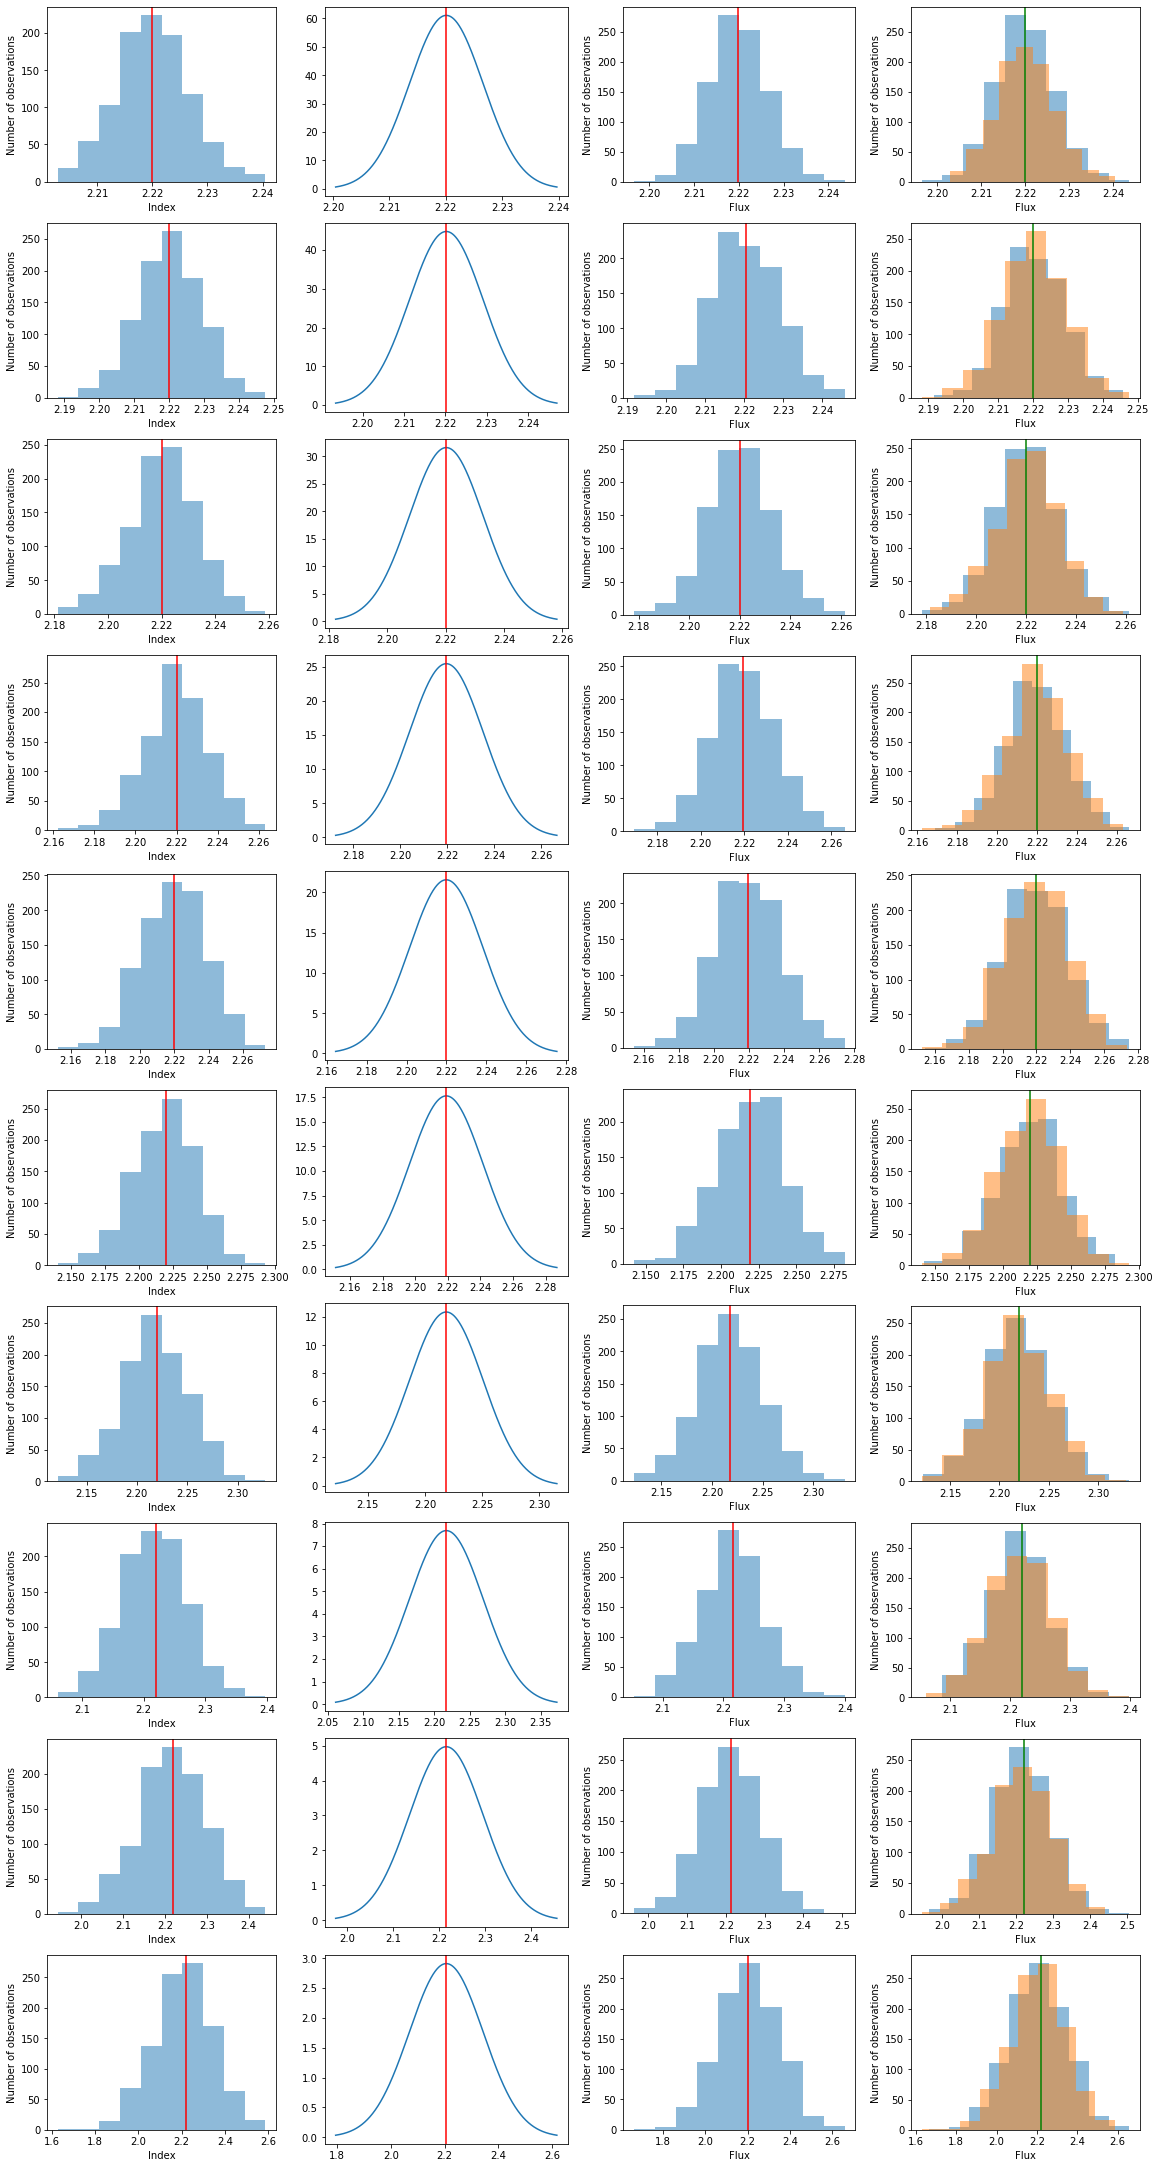

In [19]:
fig = plt.figure(figsize=[16,30],constrained_layout=True)

import matplotlib.gridspec as gridspec

gs0 = gridspec.GridSpec(1, 4, figure=fig)

gs1 = gridspec.GridSpecFromSubplotSpec(10, 1, subplot_spec=gs0[0])
for n in range(1):
    ax = fig.add_subplot(gs1[n])
    plt.hist(index[n], bins=10, alpha=0.5)
    plt.axvline(x=model_simu.parameters["index"].value, color="red")
    plt.xlabel("Index")
    plt.ylabel("Number of observations")
    print(f"index: {index[n].mean()} += {index[n].std()}")
    
for n in range(9):
    ax = fig.add_subplot(gs1[n+1])
    plt.hist(index[n+1], bins=10, alpha=0.5)
    plt.axvline(x=simu[n].parameters["index"].value, color="red")
    plt.xlabel("Index")
    plt.ylabel("Number of observations")
    print(f"index: {index[n+1].mean()} += {index[n+1].std()}")
    
gs2 = gridspec.GridSpecFromSubplotSpec(10, 1, subplot_spec=gs0[1])
for n in range(10):
    ax = fig.add_subplot(gs2[n])
    mu[n] = index[n].mean()
    sigma[n] = index[n].std()
    x = np.linspace(mu[n] - 3*sigma[n], mu[n] + 3*sigma[n], n_obs)
    plt.plot(x, stats.norm.pdf(x, mu[n], sigma[n]))
    plt.axvline(x=mu[n], color="red")

gs3 = gridspec.GridSpecFromSubplotSpec(10, 1, subplot_spec=gs0[2])
for n in range(10):
    ax = fig.add_subplot(gs3[n])
    np_hist[n] = np.random.normal(loc=mu[n], scale=sigma[n], size=n_obs)
    mu[n] = np_hist[n].mean()
    sigma[n] = np_hist[n].std()
    plt.hist(x=np_hist[n], bins=10, alpha=0.5)
    plt.axvline(x=mu[n], color="red")
    plt.xlabel('Flux')
    plt.ylabel('Number of observations')
    
gs4 = gridspec.GridSpecFromSubplotSpec(10, 1, subplot_spec=gs0[3])
for n in range(1):
    ax = fig.add_subplot(gs4[n])
    plt.hist(x=np_hist[n], bins=10, alpha=0.5)
    plt.hist(index[n], bins=10, alpha=0.5)
    plt.axvline(x=model_simu.parameters["index"].value, color="green")
    plt.xlabel('Flux')
    plt.ylabel('Number of observations')
    
for n in range(9):
    ax = fig.add_subplot(gs4[n+1])
    plt.hist(x=np_hist[n+1], bins=10, alpha=0.5)
    plt.hist(index[n+1], bins=10, alpha=0.5)
    plt.axvline(x=simu[n].parameters["index"].value, color="green")
    plt.xlabel('Flux')
    plt.ylabel('Number of observations')
    

plt.show()

amplitude: 1.2886653012289732e-12 += 1.400903308050667e-14
amplitude: 1.2888001977871752e-12 += 1.8528743940432024e-14
amplitude: 1.2892348656311055e-12 += 2.892678630292396e-14
amplitude: 1.2903492411315216e-12 += 3.8636668344198056e-14
amplitude: 1.290859892439188e-12 += 4.8297950606788555e-14
amplitude: 1.2930148098030494e-12 += 6.407439067467697e-14
amplitude: 1.2975175980804829e-12 += 1.0035524504264615e-13
amplitude: 1.3132609579926914e-12 += 1.8380732543705423e-13
amplitude: 1.3415187857487908e-12 += 3.222787493437153e-13
amplitude: 1.4841968226111473e-12 += 7.09176445369075e-13


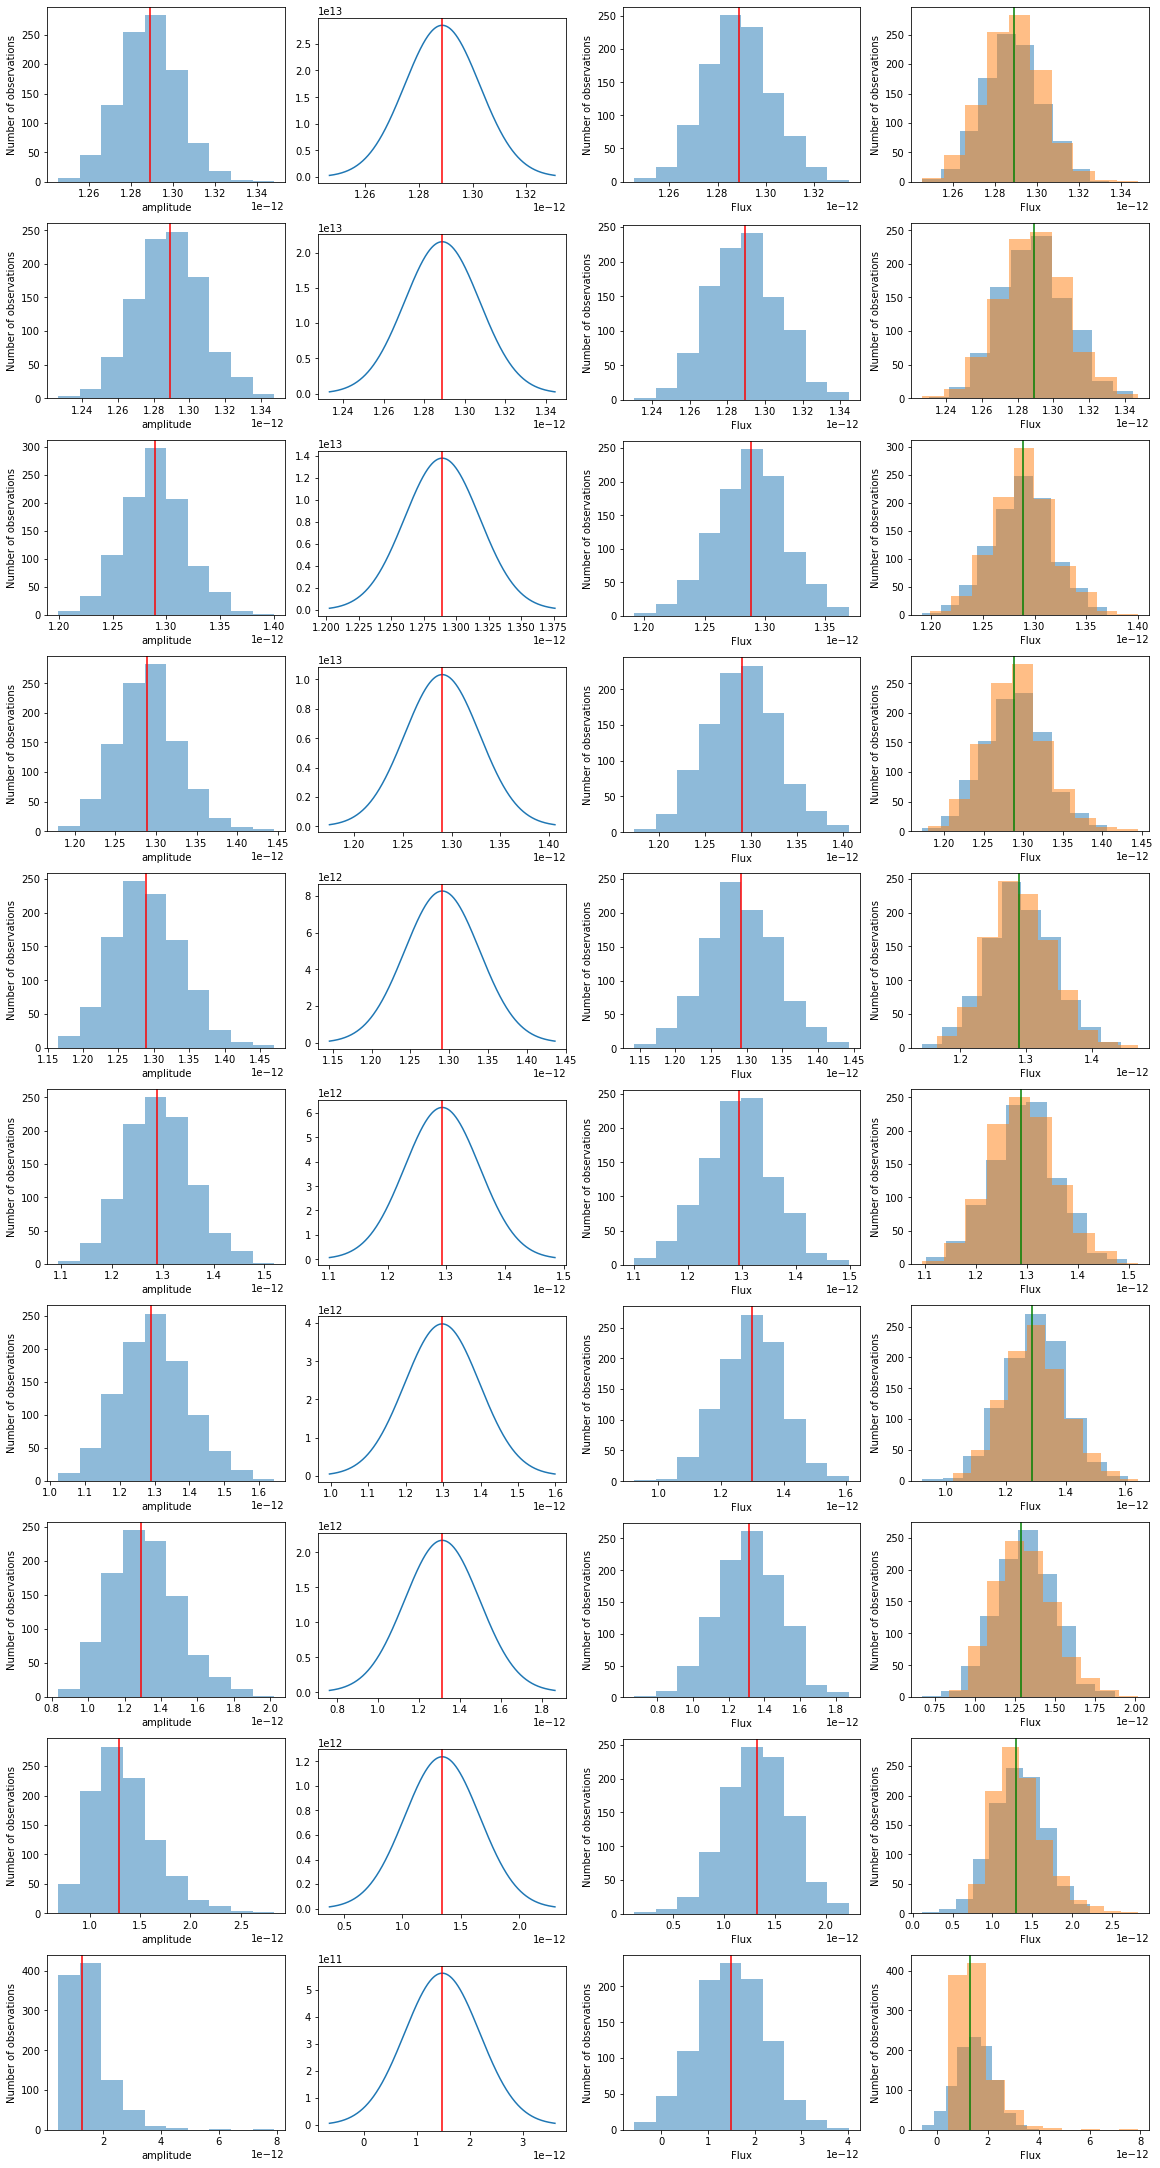

In [20]:
fig = plt.figure(figsize=[16,30],constrained_layout=True)

import matplotlib.gridspec as gridspec

gs0 = gridspec.GridSpec(1, 4, figure=fig)

gs1 = gridspec.GridSpecFromSubplotSpec(10, 1, subplot_spec=gs0[0])
for n in range(1):
    ax = fig.add_subplot(gs1[n])
    plt.hist(amplitude[n], bins=10, alpha=0.5)
    plt.axvline(x=model_simu.parameters["amplitude"].value, color="red")
    plt.xlabel("amplitude")
    plt.ylabel("Number of observations")
    print(f"amplitude: {amplitude[n].mean()} += {amplitude[n].std()}")
    
for n in range(9):
    ax = fig.add_subplot(gs1[n+1])
    plt.hist(amplitude[n+1], bins=10, alpha=0.5)
    plt.axvline(x=simu[n].parameters["amplitude"].value, color="red")
    plt.xlabel("amplitude")
    plt.ylabel("Number of observations")
    print(f"amplitude: {amplitude[n+1].mean()} += {amplitude[n+1].std()}")
    
gs2 = gridspec.GridSpecFromSubplotSpec(10, 1, subplot_spec=gs0[1])
for n in range(10):
    ax = fig.add_subplot(gs2[n])
    mu[n] = amplitude[n].mean()
    sigma[n] = amplitude[n].std()
    x = np.linspace(mu[n] - 3*sigma[n], mu[n] + 3*sigma[n], n_obs)
    plt.plot(x, stats.norm.pdf(x, mu[n], sigma[n]))
    plt.axvline(x=mu[n], color="red")

gs3 = gridspec.GridSpecFromSubplotSpec(10, 1, subplot_spec=gs0[2])
for n in range(10):
    ax = fig.add_subplot(gs3[n])
    np_hist[n] = np.random.normal(loc=mu[n], scale=sigma[n], size=n_obs)
    mu[n] = np_hist[n].mean()
    sigma[n] = np_hist[n].std()
    plt.hist(x=np_hist[n], bins=10, alpha=0.5)
    plt.axvline(x=mu[n], color="red")
    plt.xlabel('Flux')
    plt.ylabel('Number of observations')
    
gs4 = gridspec.GridSpecFromSubplotSpec(10, 1, subplot_spec=gs0[3])
for n in range(1):
    ax = fig.add_subplot(gs4[n])
    plt.hist(x=np_hist[n], bins=10, alpha=0.5)
    plt.hist(amplitude[n], bins=10, alpha=0.5)
    plt.axvline(x=model_simu.parameters["amplitude"].value, color="green")
    plt.xlabel('Flux')
    plt.ylabel('Number of observations')
    
for n in range(9):
    ax = fig.add_subplot(gs4[n+1])
    plt.hist(x=np_hist[n+1], bins=10, alpha=0.5)
    plt.hist(amplitude[n+1], bins=10, alpha=0.5)
    plt.axvline(x=simu[n].parameters["amplitude"].value, color="green")
    plt.xlabel('Flux')
    plt.ylabel('Number of observations')
    

plt.show()

lambda_: 0.010071288361913924 += 0.0026380925210984937
lambda_: 0.10020289314880353 += 0.00873895575173665
lambda_: 0.2008948816793453 += 0.01565158554889314
lambda_: 0.30122953264520774 += 0.02285608468832824
lambda_: 0.5027399829048604 += 0.03695976942784828
lambda_: 1.0048750845342644 += 0.07970575620569204
lambda_: 2.0189638337208007 += 0.2035076794342799
lambda_: 3.025322174435467 += 0.41379045779060986
lambda_: 5.116847908726059 += 0.9653616264515855


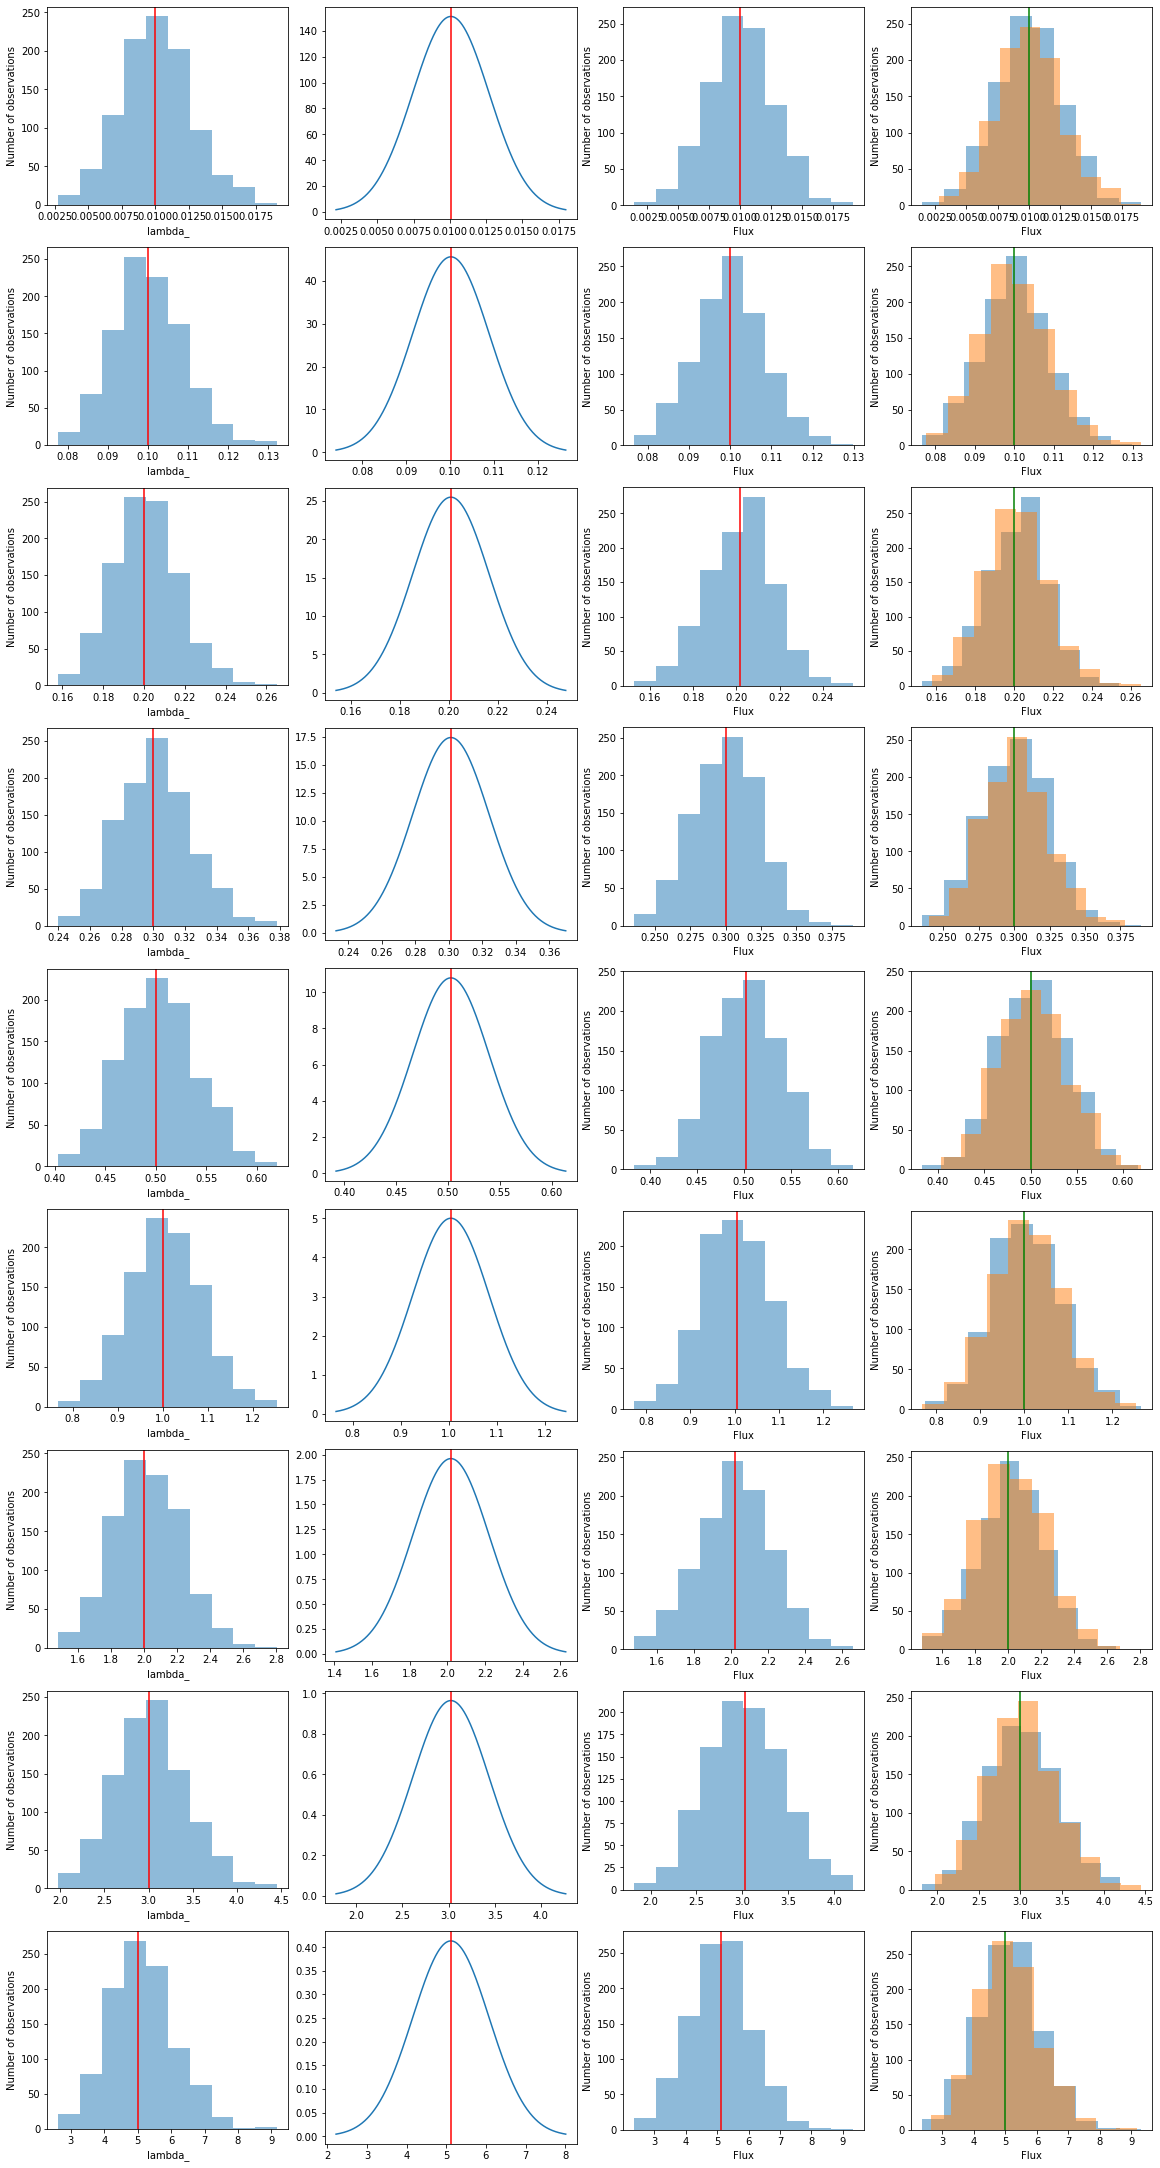

In [21]:
fig = plt.figure(figsize=[16,30],constrained_layout=True)

import matplotlib.gridspec as gridspec

gs0 = gridspec.GridSpec(1, 4, figure=fig)

gs1 = gridspec.GridSpecFromSubplotSpec(9, 1, subplot_spec=gs0[0])
for n in range(9):
    ax = fig.add_subplot(gs1[n])
    plt.hist(lambda_[n], bins=10, alpha=0.5)
    plt.axvline(x=simu[n].parameters["lambda_"].value, color="red")
    plt.xlabel("lambda_")
    plt.ylabel("Number of observations")
    print(f"lambda_: {lambda_[n].mean()} += {lambda_[n].std()}")
    
gs2 = gridspec.GridSpecFromSubplotSpec(9, 1, subplot_spec=gs0[1])
for n in range(9):
    ax = fig.add_subplot(gs2[n])
    mu[n] = lambda_[n].mean()
    sigma[n] = lambda_[n].std()
    x = np.linspace(mu[n] - 3*sigma[n], mu[n] + 3*sigma[n], n_obs)
    plt.plot(x, stats.norm.pdf(x, mu[n], sigma[n]))
    plt.axvline(x=mu[n], color="red")

gs3 = gridspec.GridSpecFromSubplotSpec(9, 1, subplot_spec=gs0[2])
for n in range(9):
    ax = fig.add_subplot(gs3[n])
    np_hist[n] = np.random.normal(loc=mu[n], scale=sigma[n], size=n_obs)
    mu[n] = np_hist[n].mean()
    sigma[n] = np_hist[n].std()
    plt.hist(x=np_hist[n], bins=10, alpha=0.5)
    plt.axvline(x=mu[n], color="red")
    plt.xlabel('Flux')
    plt.ylabel('Number of observations')
    
gs4 = gridspec.GridSpecFromSubplotSpec(9, 1, subplot_spec=gs0[3])    
for n in range(9):
    ax = fig.add_subplot(gs4[n])
    plt.hist(x=np_hist[n], bins=10, alpha=0.5)
    plt.hist(lambda_[n], bins=10, alpha=0.5)
    plt.axvline(x=simu[n].parameters["lambda_"].value, color="green")
    plt.xlabel('Flux')
    plt.ylabel('Number of observations')
    

plt.show()

In [22]:
sim = [] 
s = PowerLawSpectralModel(
    index=index[0].mean(),
    amplitude=amplitude[0].mean() * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
)
print(s)
sim.append(s)

for i in range(9):
    s = ExpCutoffPowerLawSpectralModel(
        index=index[i+1].mean(),
        amplitude=amplitude[i+1].mean() * u.Unit("cm-2 s-1 TeV-1"),
        reference=1 * u.TeV,
        lambda_=lambda_[i].mean() * u.Unit("TeV-1"),
        alpha = 1,
    )
    print(s)
    sim.append(s)

PowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
ExpCutoffPowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.007e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
ExpCutoffPowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+

<function matplotlib.pyplot.show(*args, **kw)>

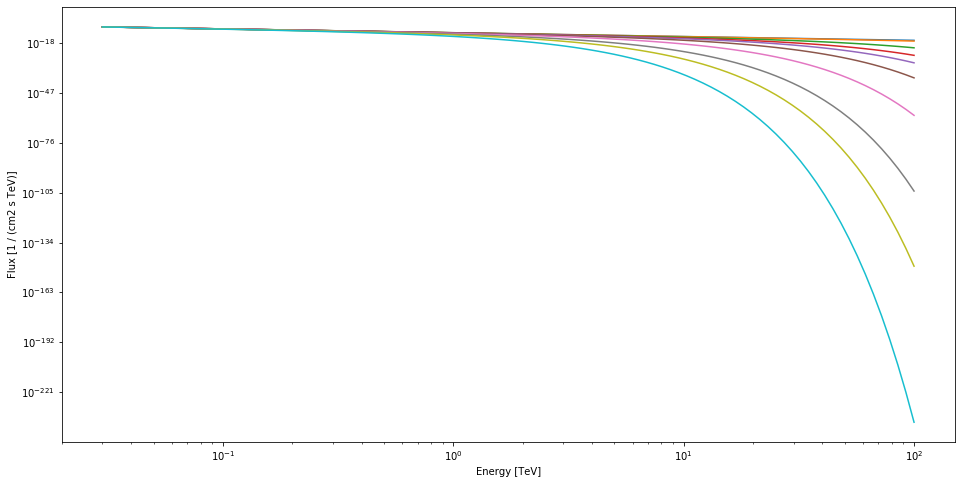

In [23]:
plt.figure(figsize=[16,8])
energy_range = [0.03, 100] * u.TeV
sim[0].plot(energy_range)
for i in range(9):
    sim[i+1].plot(energy_range)
plt.show

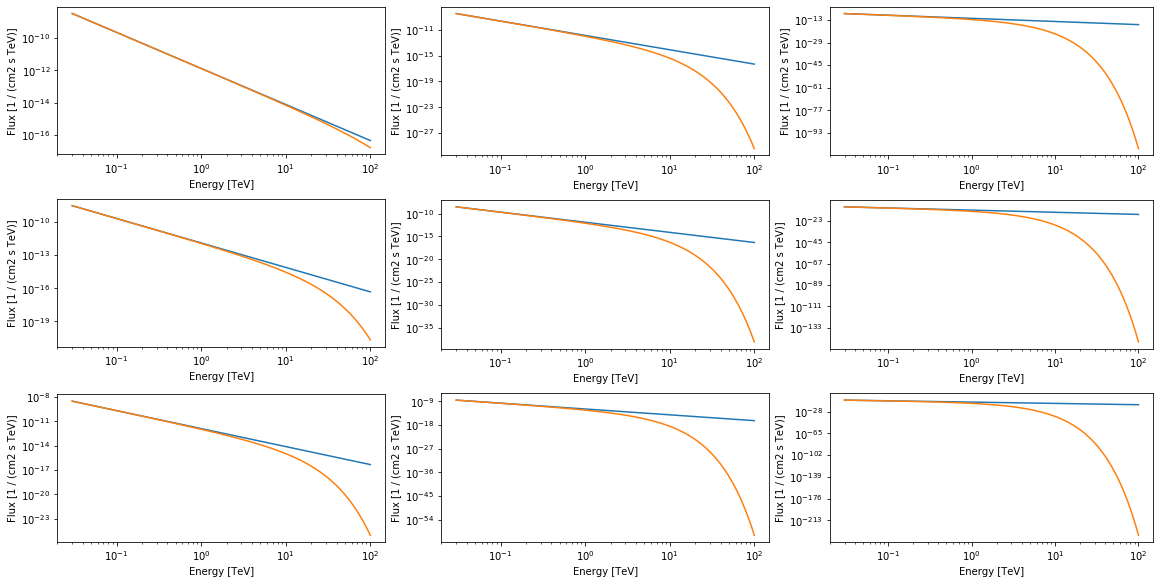

In [24]:
fig = plt.figure(figsize=[16,8],constrained_layout=True)

import matplotlib.gridspec as gridspec

gs0 = gridspec.GridSpec(1, 3, figure=fig)

gs1 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[0])
for n in range(3):
    ax = fig.add_subplot(gs1[n])
    sim[0].plot(energy_range)
    sim[n+1].plot(energy_range)

gs2 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[1])
for n in range(3):
    ax = fig.add_subplot(gs2[n])
    sim[0].plot(energy_range)
    sim[n+4].plot(energy_range)

gs3 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[2])
for n in range(3):
    ax = fig.add_subplot(gs3[n])
    sim[0].plot(energy_range)
    sim[n+7].plot(energy_range)
    
plt.show()

In [25]:
def evaluate_err(self, covar, energy, epsilon=1e-4):

        p_cov = covar
        eps = np.sqrt(np.diag(covar)) * epsilon

        df_dp = self._evaluate_gradient(energy, eps)
        f_cov = df_dp.T @ p_cov @ df_dp
        f_err = np.sqrt(np.diagonal(f_cov))

        q = self(energy)
        return u.Quantity([q.value, f_err], unit=q.unit)

In [26]:
def plot_error(
        self,
        covar,
        energy_range,
        ax=None,
        energy_unit="TeV",
        flux_unit="cm-2 s-1 TeV-1",
        energy_power=0,
        n_points=100,
        **kwargs,
    ):
        
        ax = plt.gca() if ax is None else ax

        kwargs.setdefault("facecolor", "black")
        kwargs.setdefault("alpha", 0.2)
        kwargs.setdefault("linewidth", 0)

        emin, emax = energy_range
        energy = MapAxis.from_energy_bounds(emin, emax, n_points, energy_unit).edges

        flux, flux_err = evaluate_err(self,covar,energy).to(flux_unit)

        y_lo = self._plot_scale_flux(energy, flux - flux_err, energy_power)
        y_hi = self._plot_scale_flux(energy, flux + flux_err, energy_power)

        where = (energy >= energy_range[0]) & (energy <= energy_range[1])
        ax.fill_between(energy.value, y_lo.value, y_hi.value, where=where, **kwargs)

        self._plot_format_ax(ax, energy, y_lo, energy_power)
        return ax

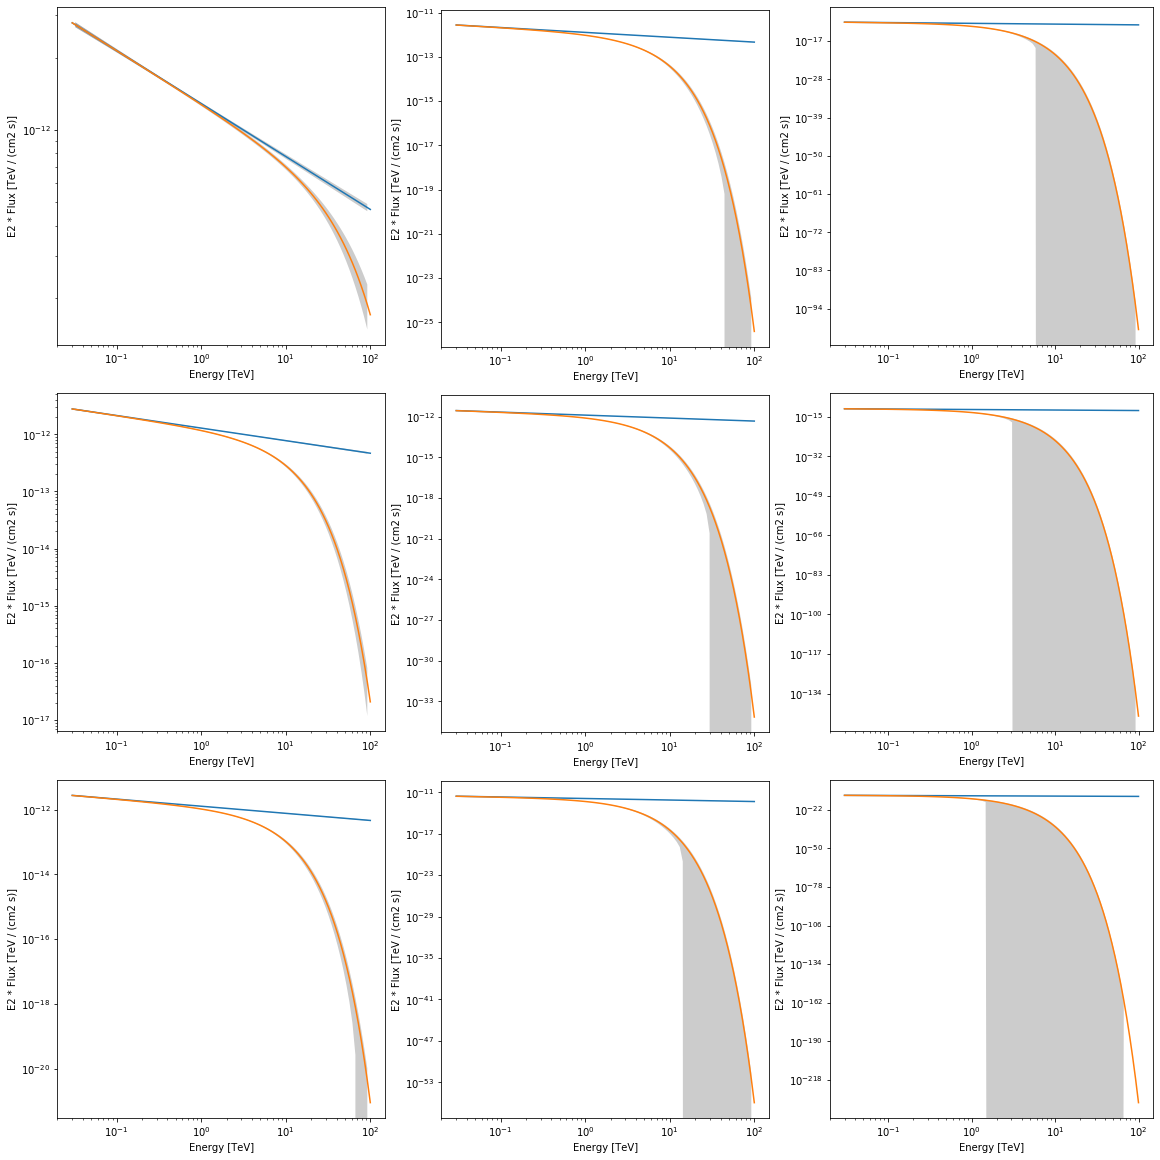

In [27]:
fig = plt.figure(figsize=[16,16],constrained_layout=True)

import matplotlib.gridspec as gridspec

gs0 = gridspec.GridSpec(1, 3, figure=fig)

gs1 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[0])
for n in range(3):
    ax = fig.add_subplot(gs1[n])
    sim[0].plot(energy_range=energy_range, energy_power=2)
    plot_error(self=sim[0], covar=covar[0],energy_range=energy_range, energy_power=2)
    sim[n+1].plot(energy_range=energy_range, energy_power=2)
    plot_error(self=sim[n+1], covar=covar[n+1],energy_range=energy_range, energy_power=2)

gs2 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[1])
for n in range(3):
    ax = fig.add_subplot(gs2[n])
    sim[0].plot(energy_range=energy_range, energy_power=2)
    plot_error(self=sim[0], covar=covar[0],energy_range=energy_range, energy_power=2)
    sim[n+4].plot(energy_range=energy_range, energy_power=2)
    plot_error(self=sim[n+4], covar=covar[n+4],energy_range=energy_range, energy_power=2)

gs3 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[2])
for n in range(3):
    ax = fig.add_subplot(gs3[n])
    sim[0].plot(energy_range=energy_range, energy_power=2)
    plot_error(self=sim[0], covar=covar[0],energy_range=energy_range, energy_power=2)
    sim[n+7].plot(energy_range=energy_range, energy_power=2)
    plot_error(self=sim[n+7], covar=covar[n+7],energy_range=energy_range, energy_power=2)
    
plt.show()